In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind

In [2]:
data_dir = '../../../datasets/ppmi/visit_feature_inputs_asof_2019Jan24_using_CMEDTM/'
pd_total_df = pd.read_csv(data_dir + 'PD_totals_across_time.csv')
pd_questions_df = pd.read_csv(data_dir + 'PD_questions_across_time.csv')

### Select 20 patients to use for visualizations

In [3]:
np.random.seed(82073)
patnos = pd_total_df.PATNO.unique()
np.random.shuffle(patnos)
selected_patnos = np.empty(20)
idx = 0
for patno in patnos:
    if idx == 20:
        break
    patno_df = pd_total_df.loc[pd_total_df['PATNO']==patno]
    patno_df = patno_df.dropna(subset=['NUPDRS3_untreated', 'NUPDRS3_off', 'NUPDRS3_on'], \
                               how='all').sort_values(by=['EVENT_ID_DUR'])
    if len(patno_df) >= 5:
        selected_patnos[idx] = patno
        idx += 1
selected_patnos

array([3589., 3471., 3312., 3954., 3831., 3705., 3083., 3225., 3972.,
       3476., 3970., 3567., 4073., 3023., 4096., 3178., 3010., 3629.,
       3556., 3869.])

### Calculate subtotals across time split by treatment

In [4]:
def get_4cond_cols(cols):
    # returns untreated, off, on, maob
    untreated_cols = []
    off_cols = []
    on_cols = []
    maob_cols = []
    for col in cols:
        if col.startswith('NP3'):
            untreated_cols.append(col+'_untreated')
            off_cols.append(col+'_off')
            on_cols.append(col+'_on')
            maob_cols.append(col+'_maob')
        else:
            untreated_cols.append(col)
            off_cols.append(col)
            on_cols.append(col)
            maob_cols.append(col)
    return untreated_cols, off_cols, on_cols, maob_cols

In [5]:
def get_cond_sum(df, cols, sum_col):
    df[sum_col] = np.where(pd.isnull(df[cols[0]]), float('NaN'), df[cols].sum(axis=1))
    return df

In [6]:
tremor_cols = ['NP3RTALL', 'NP3RTALU', 'NP3KTRML', 'NP3PTRML', 'NP3KTRMR', 'NP3PTRMR', 'NP3RTARU', \
                   'NP3RTALJ', 'NP3RTARL', 'NP2TRMR', 'NP3RTCON']
rigidity_left_cols = ['NP3RIGLU', 'NP3RIGLL', 'NP3PRSPL', 'NP3FTAPL', 'NP3HMOVL', 'NP3LGAGL', 'NP3TTAPL']
rigidity_right_cols = ['NP3RIGRL', 'NP3RIGRU', 'NP3PRSPR', 'NP3FTAPR', 'NP3HMOVR', 'NP3LGAGR', 'NP3TTAPR']
face_cols = ['NP3SPCH', 'NP3RIGN', 'NP3BRADY', 'NP3FACXP']
gait_cols = ['NP3FRZGT', 'NP3PSTBL', 'NP3RISNG', 'NP3GAIT', 'NP3POSTR']
subtotal_cols_dict = {'NUPDRS_TREMOR': tremor_cols, 'NUPDRS_RIGIDITY_LEFT': rigidity_left_cols, \
                      'NUPDRS_RIGIDITY_RIGHT': rigidity_right_cols, 'NUPDRS_FACE': face_cols, \
                      'NUPDRS_GAIT': gait_cols}
for subtotal in subtotal_cols_dict.keys():
    subtotal_untreated_cols, subtotal_off_cols, subtotal_on_cols, subtotal_maob_cols \
        = get_4cond_cols(subtotal_cols_dict[subtotal])
    pd_questions_df = get_cond_sum(pd_questions_df, subtotal_untreated_cols, subtotal + '_untreated')
    pd_questions_df = get_cond_sum(pd_questions_df, subtotal_off_cols, subtotal + '_off')
    pd_questions_df = get_cond_sum(pd_questions_df, subtotal_on_cols, subtotal + '_on')
    pd_questions_df = get_cond_sum(pd_questions_df, subtotal_maob_cols, subtotal + '_maob')

In [7]:
def get_on_off_sums(df, cols, sum_header):
    df[sum_header + '_untreated'] = np.where(~pd.isnull(df['NP3RTALL_untreated']), df[cols].sum(axis=1), float('NaN'))
    df[sum_header + '_treated'] = np.where(~pd.isnull(df['NP3RTALL_untreated']), float('NaN'), df[cols].sum(axis=1))
    return df

In [8]:
daily_activities = ['NP2HWRT', 'NP2FREZ', 'NP2HYGN', 'NP2EAT', 'NP2HOBB', 'NP2WALK', 'NP2DRES', 'NP2RISE', \
                    'NP2TURN', 'NP2SWAL', 'NP2SALV', 'NP2SPCH']
pd_questions_df = get_on_off_sums(pd_questions_df, daily_activities, 'NUPDRS_DAILYACT')

In [9]:
pd_questions_df = pd_questions_df.merge(pd_total_df[['PATNO','EVENT_ID','NUPDRS3_untreated','NUPDRS3_on',\
                                                     'NUPDRS3_off','NUPDRS3_maob']], \
                                       on=['PATNO','EVENT_ID'], how='left', validate='one_to_one')

### Fit curves to each treatment setting and make plots for each patient

In [10]:
def lin_func(x, a, b):
    return a*x + b

def quadratic_func(x, a, b, c):
    return a*x**2 + b*x + c

def piecewise_lin_func(x, a, b, c, d, e):
    return np.piecewise(x, [x < e], [lambda x: a*x + b, lambda x: c*x + d])

In [12]:
nupdrs_col_headers = ['NUPDRS_TREMOR', 'NUPDRS_RIGIDITY_LEFT', 'NUPDRS_RIGIDITY_RIGHT', 'NUPDRS_FACE', 'NUPDRS_GAIT', \
                      'NUPDRS_DAILYACT', 'NUPDRS3']
nupdrs_col_labels = ['Tremor', 'Rigidity left', 'Rigidity right', 'Face', 'Gait', 'Part II', 'Part III']
plt.rcParams.update({'font.size': 18})
def make_mdsupdrs_plot(df, func_fit='linear', offset=0):
    assert func_fit in {'linear', 'piecewise_linear', 'quadratic'}
    if func_fit == 'linear':
        func = lin_func
        num_params = 2
    elif func_fit == 'piecewise_linear':
        func = piecewise_lin_func
        num_params = 5
    else:
        func = quadratic_func
        num_params = 3
    # to avoid misspecification, the number of points must be at least the number of parameters before fitting
    num_rows = 5
    num_cols = len(nupdrs_col_headers)
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))
    for row_idx in range(num_rows):
        patno = selected_patnos[row_idx+offset]
        patno_df = df.loc[df['PATNO']==patno]
        for col_idx in range(len(nupdrs_col_headers)):
            col_header = nupdrs_col_headers[col_idx]
            if col_header != 'NUPDRS_DAILYACT':
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_off',col_header+'_on',\
                                               col_header+'_maob'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
            else:
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_treated'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
       
            untreated_df = patno_col_df.dropna(subset=[col_header+'_untreated'])
            untreated_times = untreated_df.EVENT_ID_DUR.values
            untreated_values = untreated_df[col_header+'_untreated'].values
            if len(untreated_times) > 0:
                ax[row_idx, col_idx].scatter(untreated_times, untreated_values, c='b', label='untreated')
                if len(untreated_times) >= num_params:
                    untreated_params, _ = curve_fit(func, untreated_times, untreated_values)
                    untreated_smooth_xs = 0.01*np.arange(100*np.min(untreated_times), 100*np.max(untreated_times))
                    ax[row_idx, col_idx].plot(untreated_smooth_xs, func(untreated_smooth_xs, *untreated_params), 'b')
            ax[row_idx, col_idx].set_title(nupdrs_col_labels[col_idx])
            if col_header != 'NUPDRS_DAILYACT':
                off_df = patno_col_df.dropna(subset=[col_header+'_off'])
                off_times = off_df.EVENT_ID_DUR.values
                off_values = off_df[col_header+'_off'].values
                if len(off_times) > 0:
                    ax[row_idx, col_idx].scatter(off_times, off_values, c='g', label='"off" meds')
                    if len(off_times) >= num_params:
                        off_params, _ = curve_fit(func, off_times, off_values)
                        off_smooth_xs = 0.01*np.arange(100*np.min(off_times), 100*np.max(off_times))
                        ax[row_idx, col_idx].plot(off_smooth_xs, func(off_smooth_xs, *off_params), 'g')

                on_df = patno_col_df.dropna(subset=[col_header+'_on'])
                on_times = on_df.EVENT_ID_DUR.values
                on_values = on_df[col_header+'_on'].values
                if len(on_times) > 0:
                    ax[row_idx, col_idx].scatter(on_times, on_values, c='r', label='"on" meds')
                    if len(on_times) >= num_params:
                        on_params, _ = curve_fit(func, on_times, on_values)
                        
                        on_smooth_xs = 0.01*np.arange(100*np.min(on_times), 100*np.max(on_times))
                        ax[row_idx, col_idx].plot(on_smooth_xs, func(on_smooth_xs, *on_params), 'r')

                maob_df = patno_col_df.dropna(subset=[col_header+'_maob'])
                maob_times = maob_df.EVENT_ID_DUR.values
                maob_values = maob_df[col_header+'_maob'].values
                if len(maob_times) > 0:
                    ax[row_idx, col_idx].scatter(maob_times, maob_values, c='y', label='MAO-B')
                    if len(maob_times) >= num_params:
                        maob_params, _ = curve_fit(func, maob_times, maob_values)
                        maob_smooth_xs = 0.01*np.arange(100*np.min(maob_times), 100*np.max(maob_times))
                        ax[row_idx, col_idx].plot(maob_smooth_xs, func(maob_smooth_xs, *maob_params), 'y')
            else:
                treated_df = patno_col_df.dropna(subset=[col_header+'_treated'])
                treated_times = treated_df.EVENT_ID_DUR.values
                treated_values = treated_df[col_header+'_treated'].values
                if len(treated_times) > 0:
                    ax[row_idx, col_idx].scatter(treated_times, treated_values, c='r', label='treated')
                    if len(treated_times) >= num_params:
                        treated_params, _ = curve_fit(func, treated_times, treated_values)
                        treated_smooth_xs = 0.01*np.arange(100*np.min(treated_times), 100*np.max(treated_times))
                        ax[row_idx, col_idx].plot(treated_smooth_xs, func(treated_smooth_xs, *treated_params), 'r')
                        
    plt.tight_layout()
    plt.legend()
    plt.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


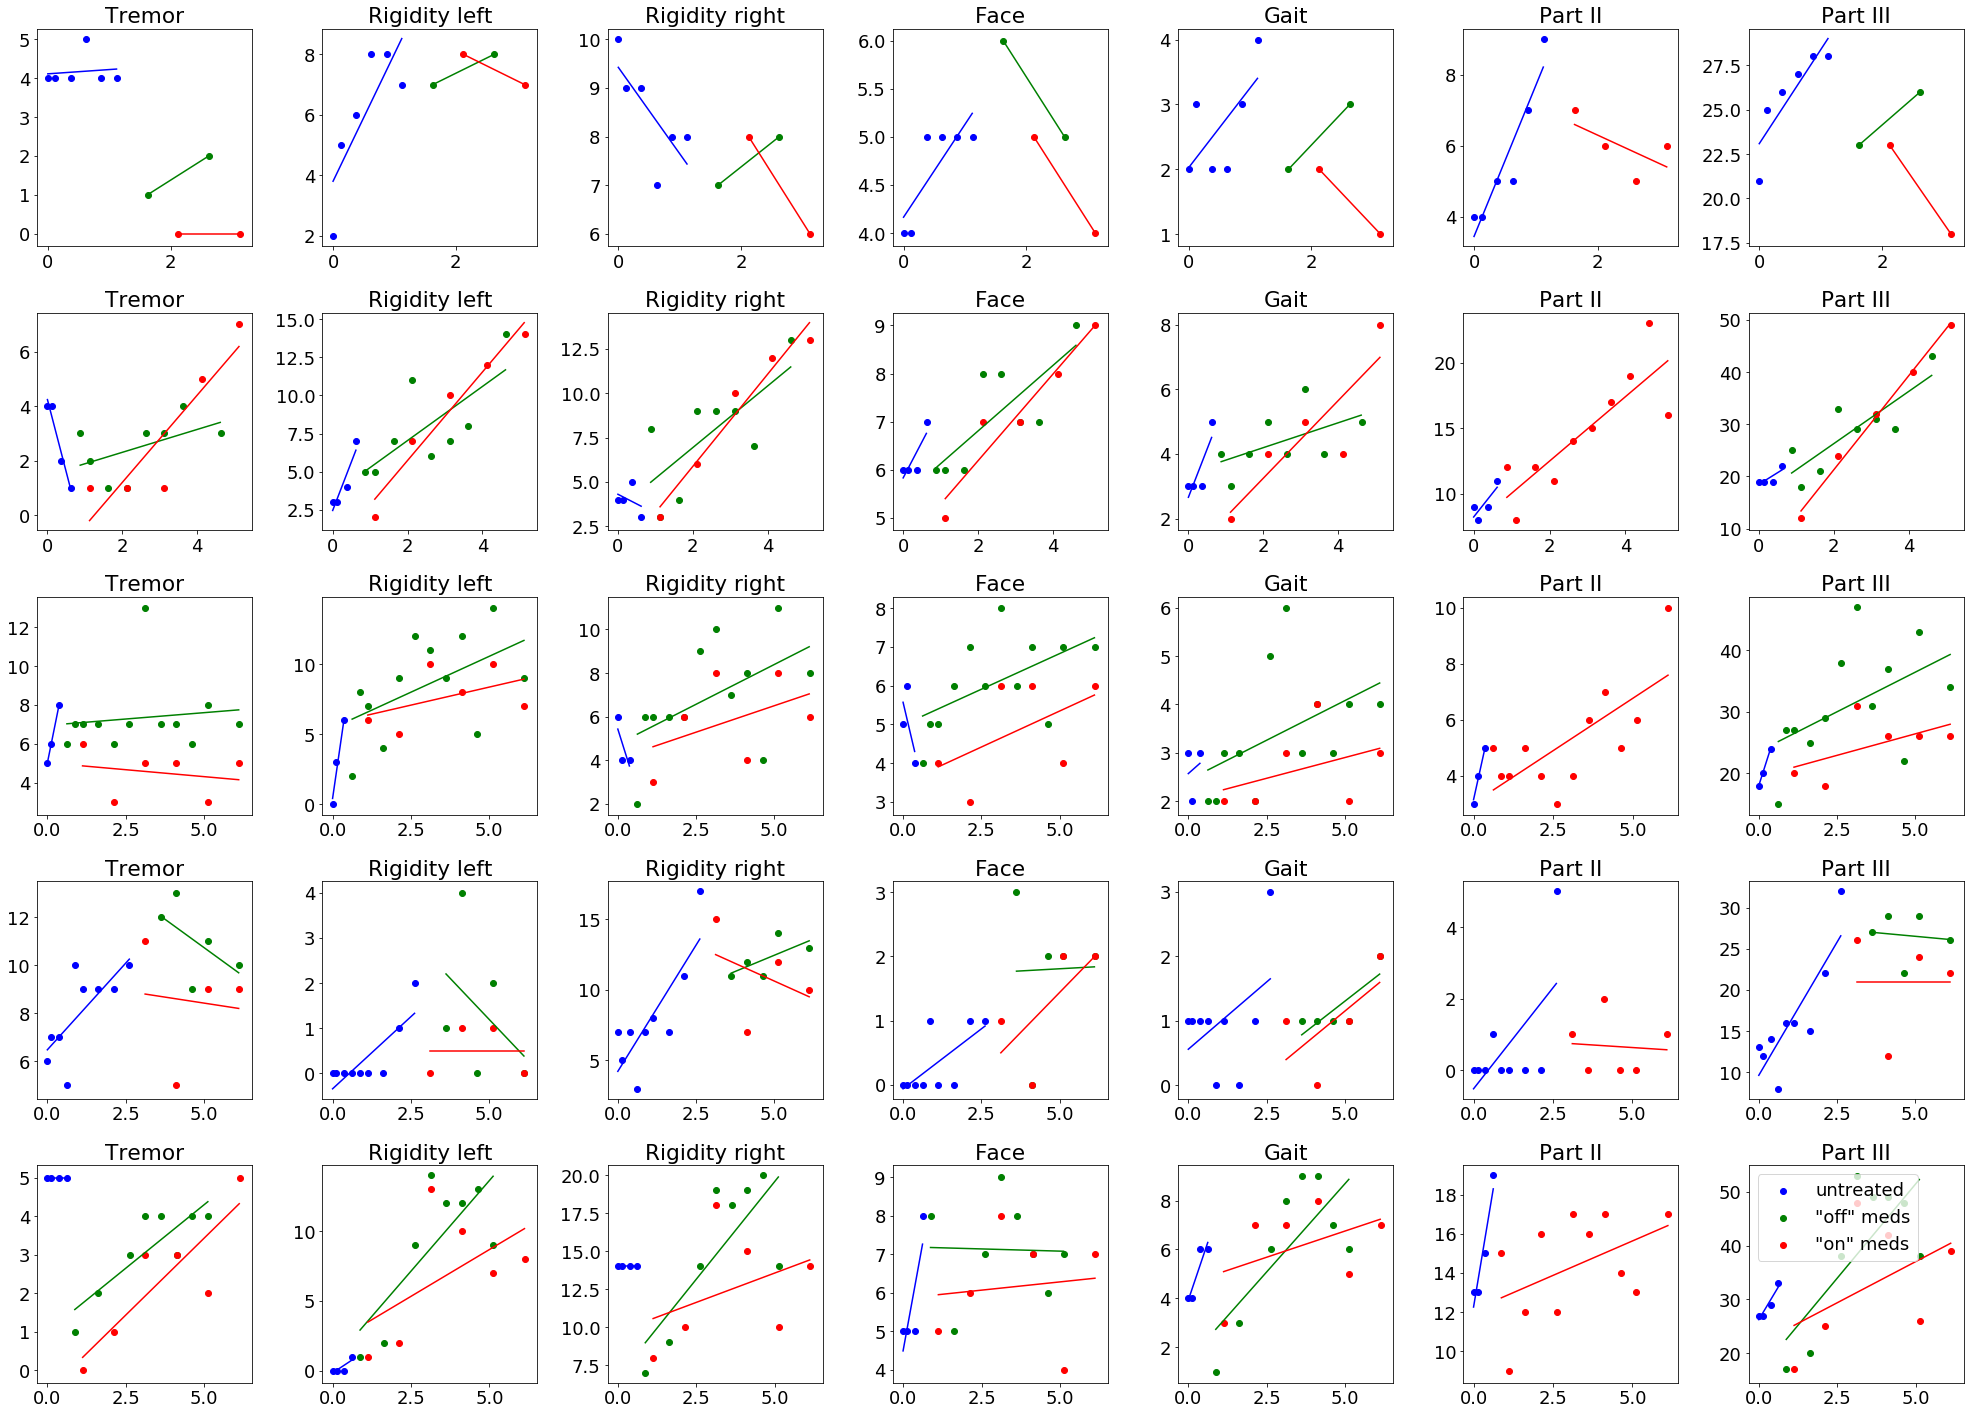

In [13]:
make_mdsupdrs_plot(pd_questions_df)

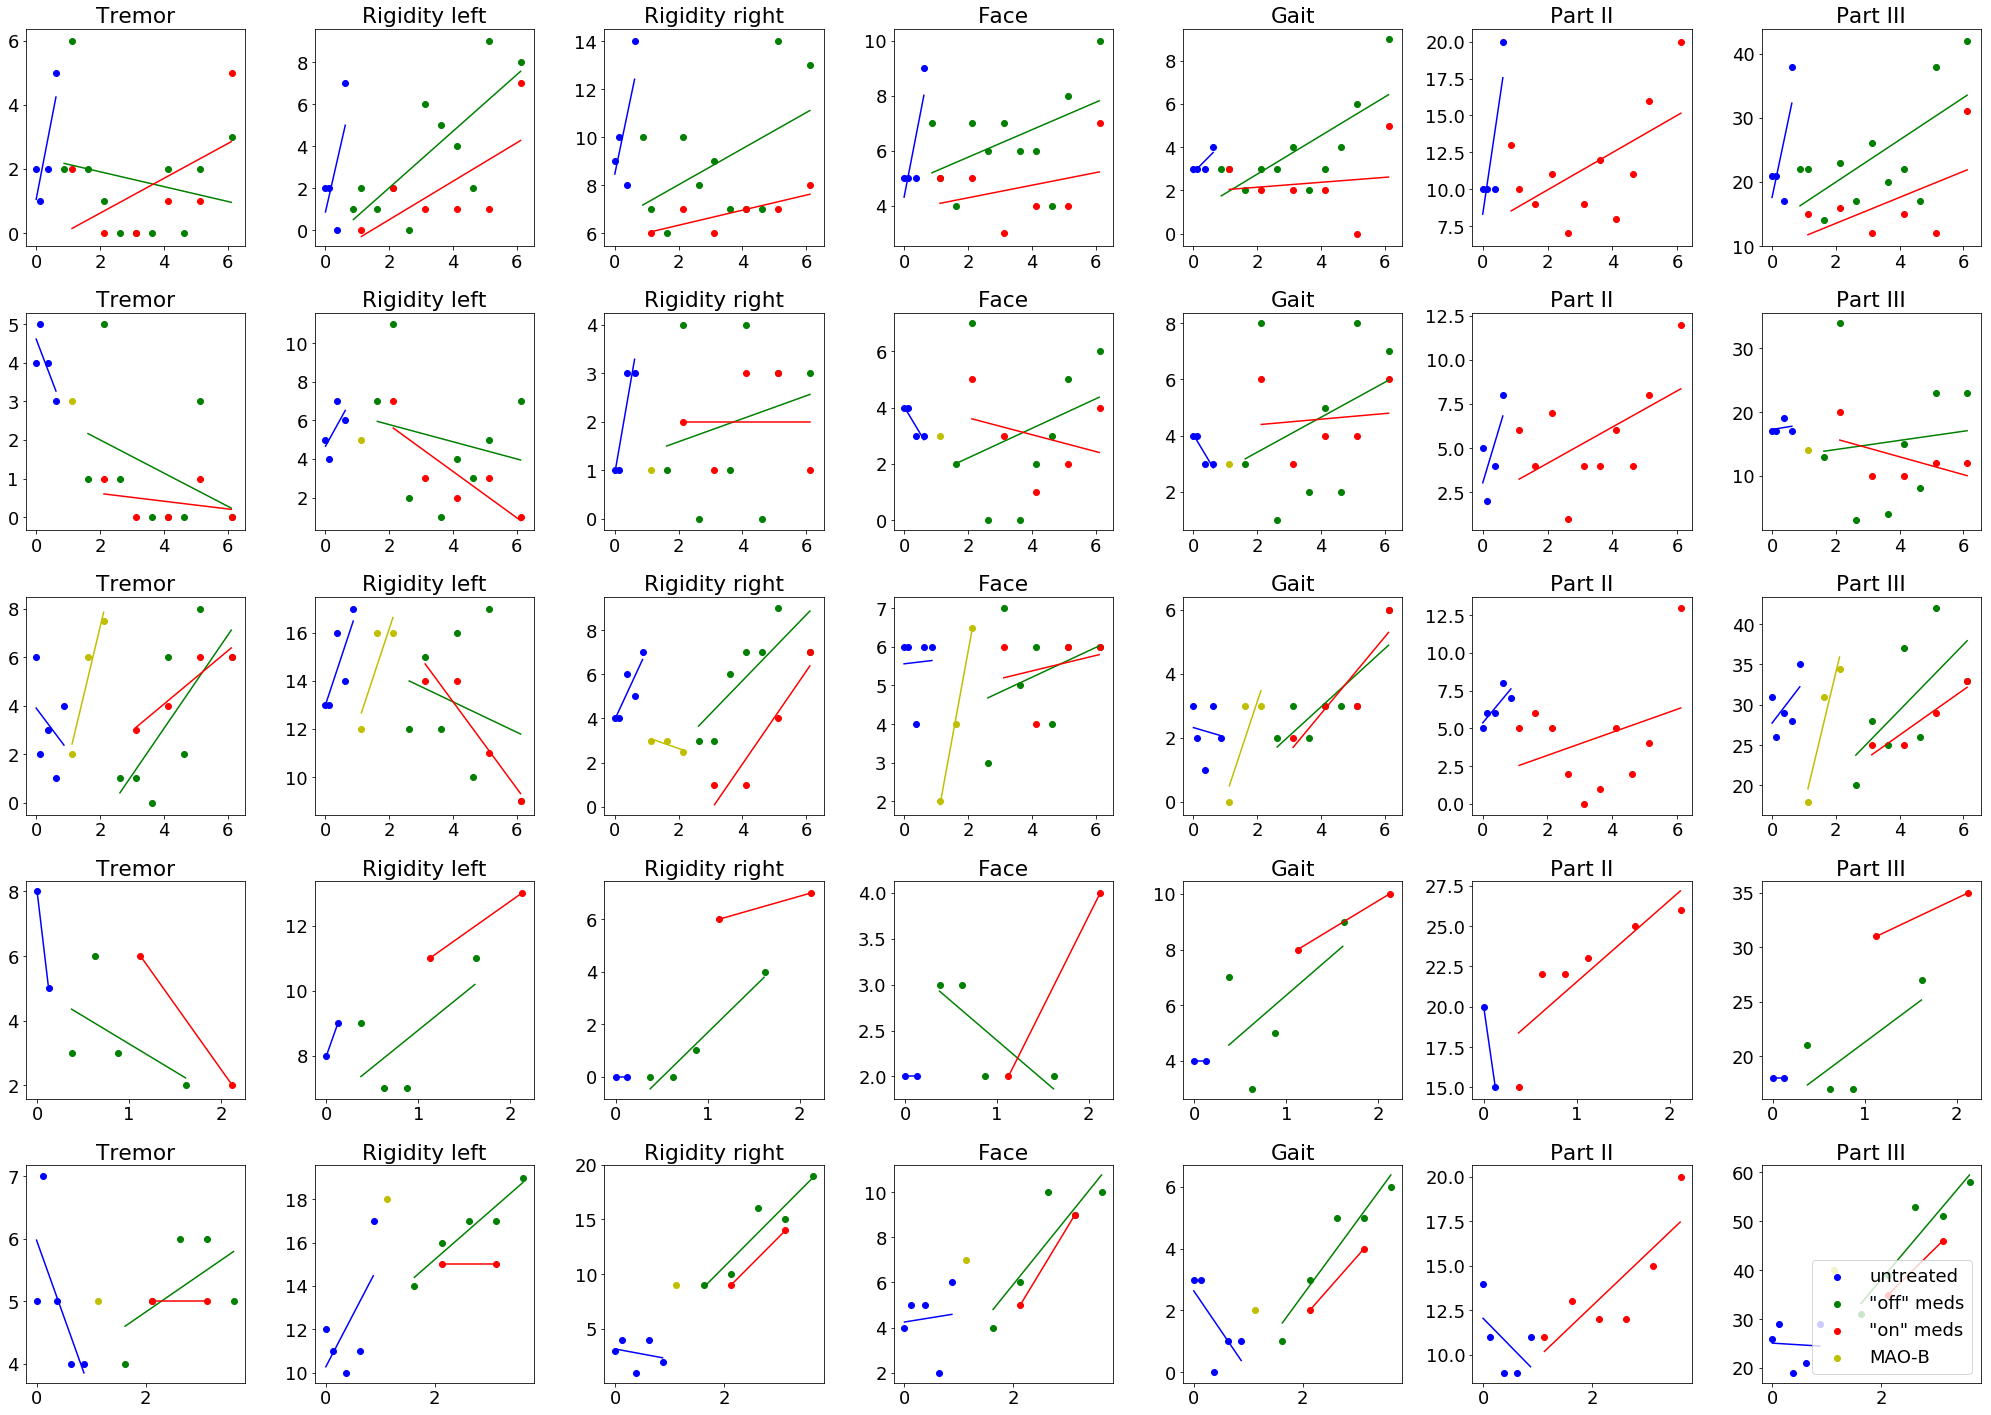

In [14]:
make_mdsupdrs_plot(pd_questions_df, offset=5)

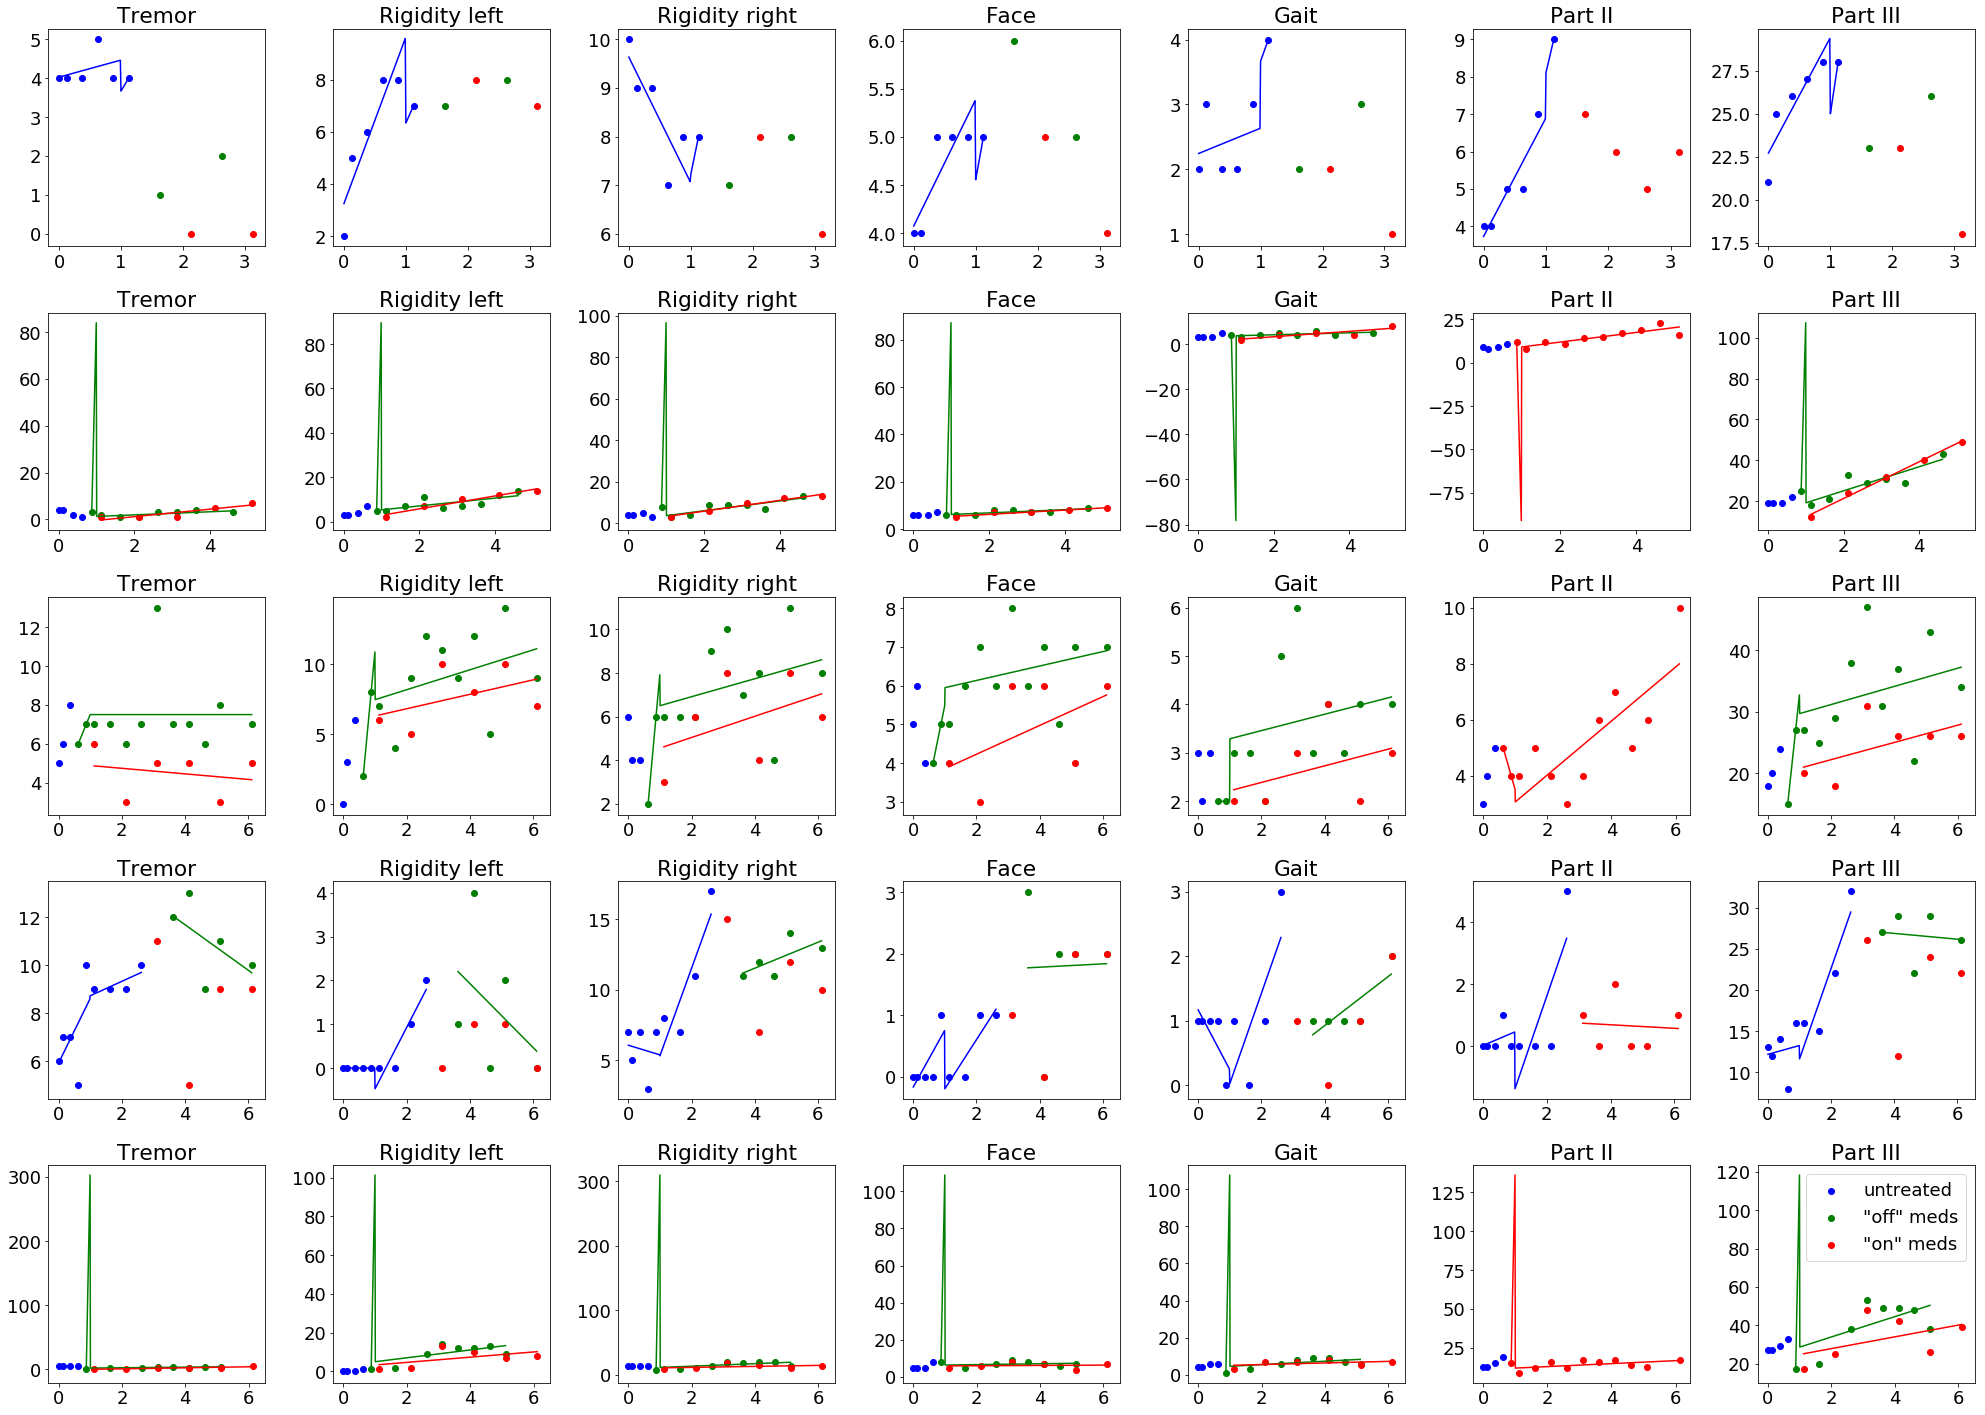

In [15]:
make_mdsupdrs_plot(pd_questions_df, func_fit='piecewise_linear')

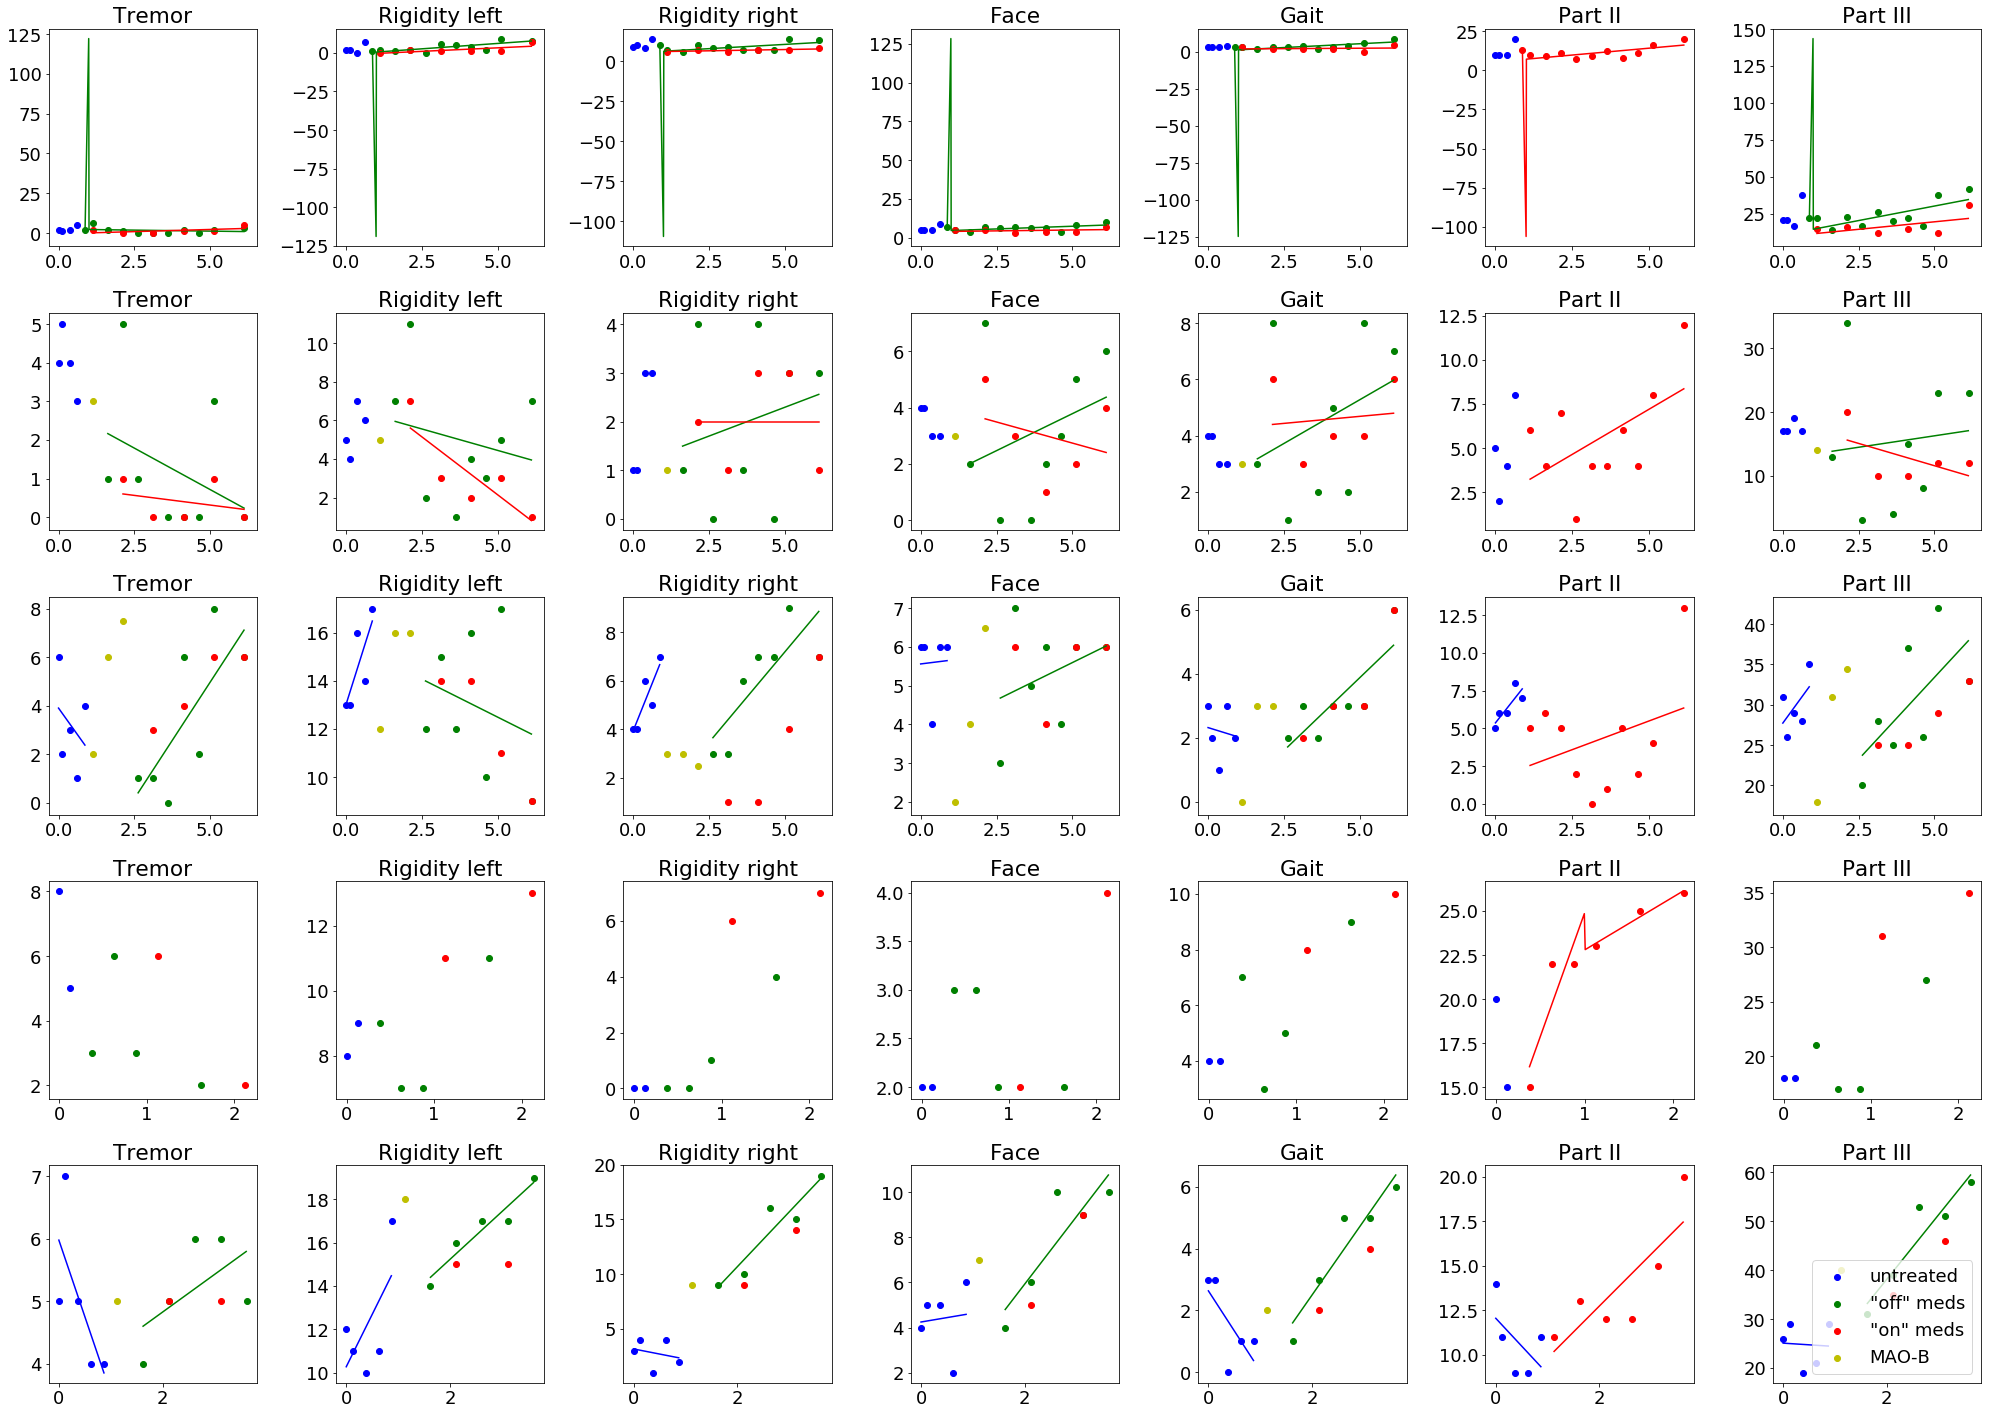

In [16]:
make_mdsupdrs_plot(pd_questions_df, func_fit='piecewise_linear', offset=5)

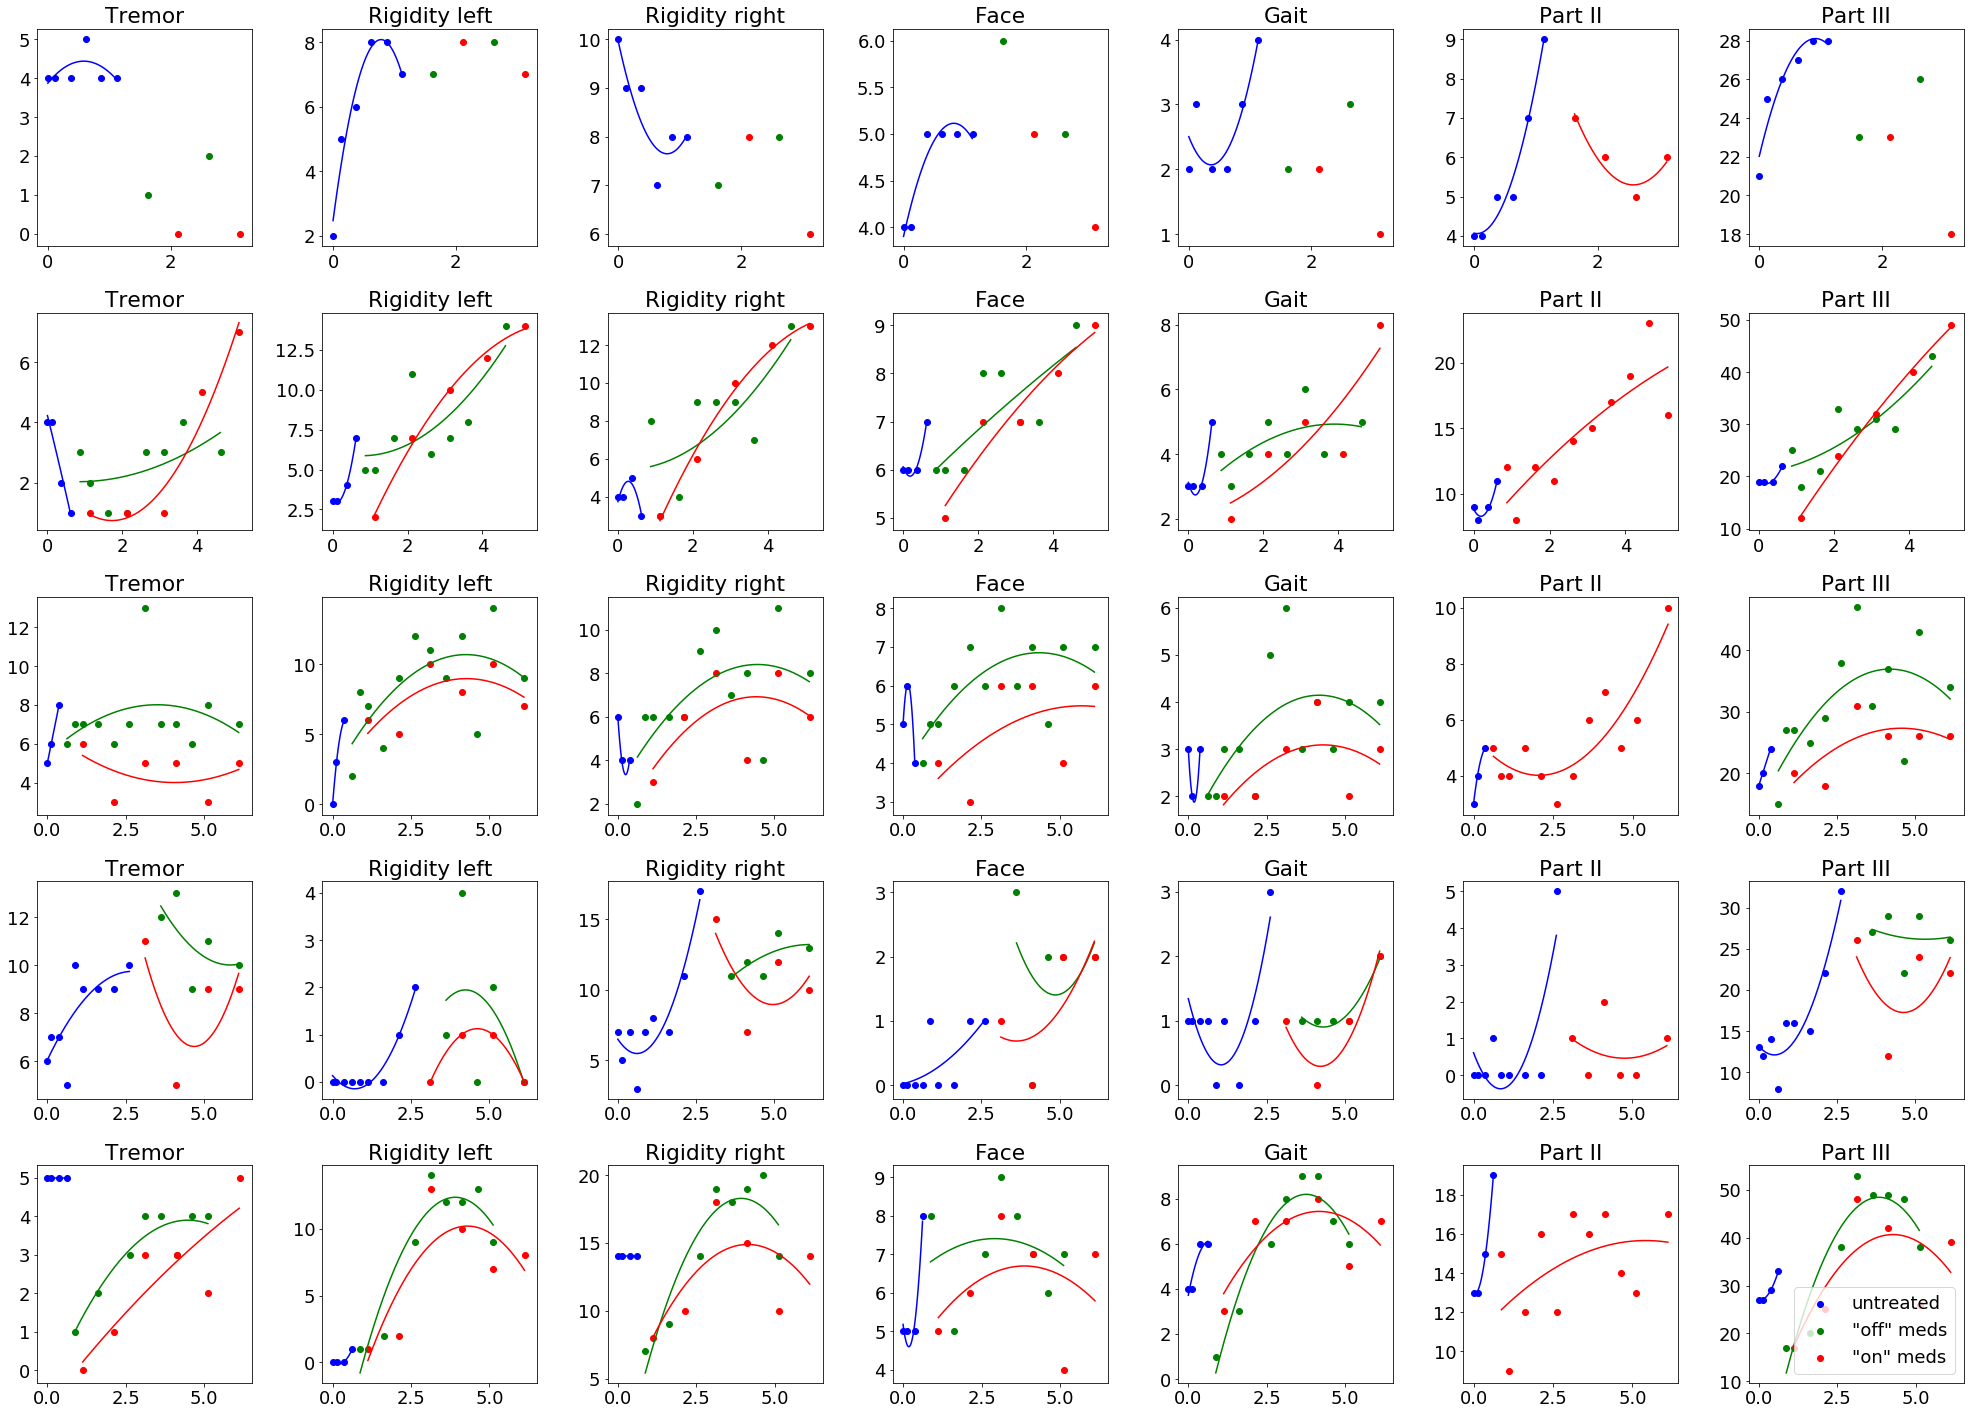

In [17]:
make_mdsupdrs_plot(pd_questions_df, func_fit='quadratic')

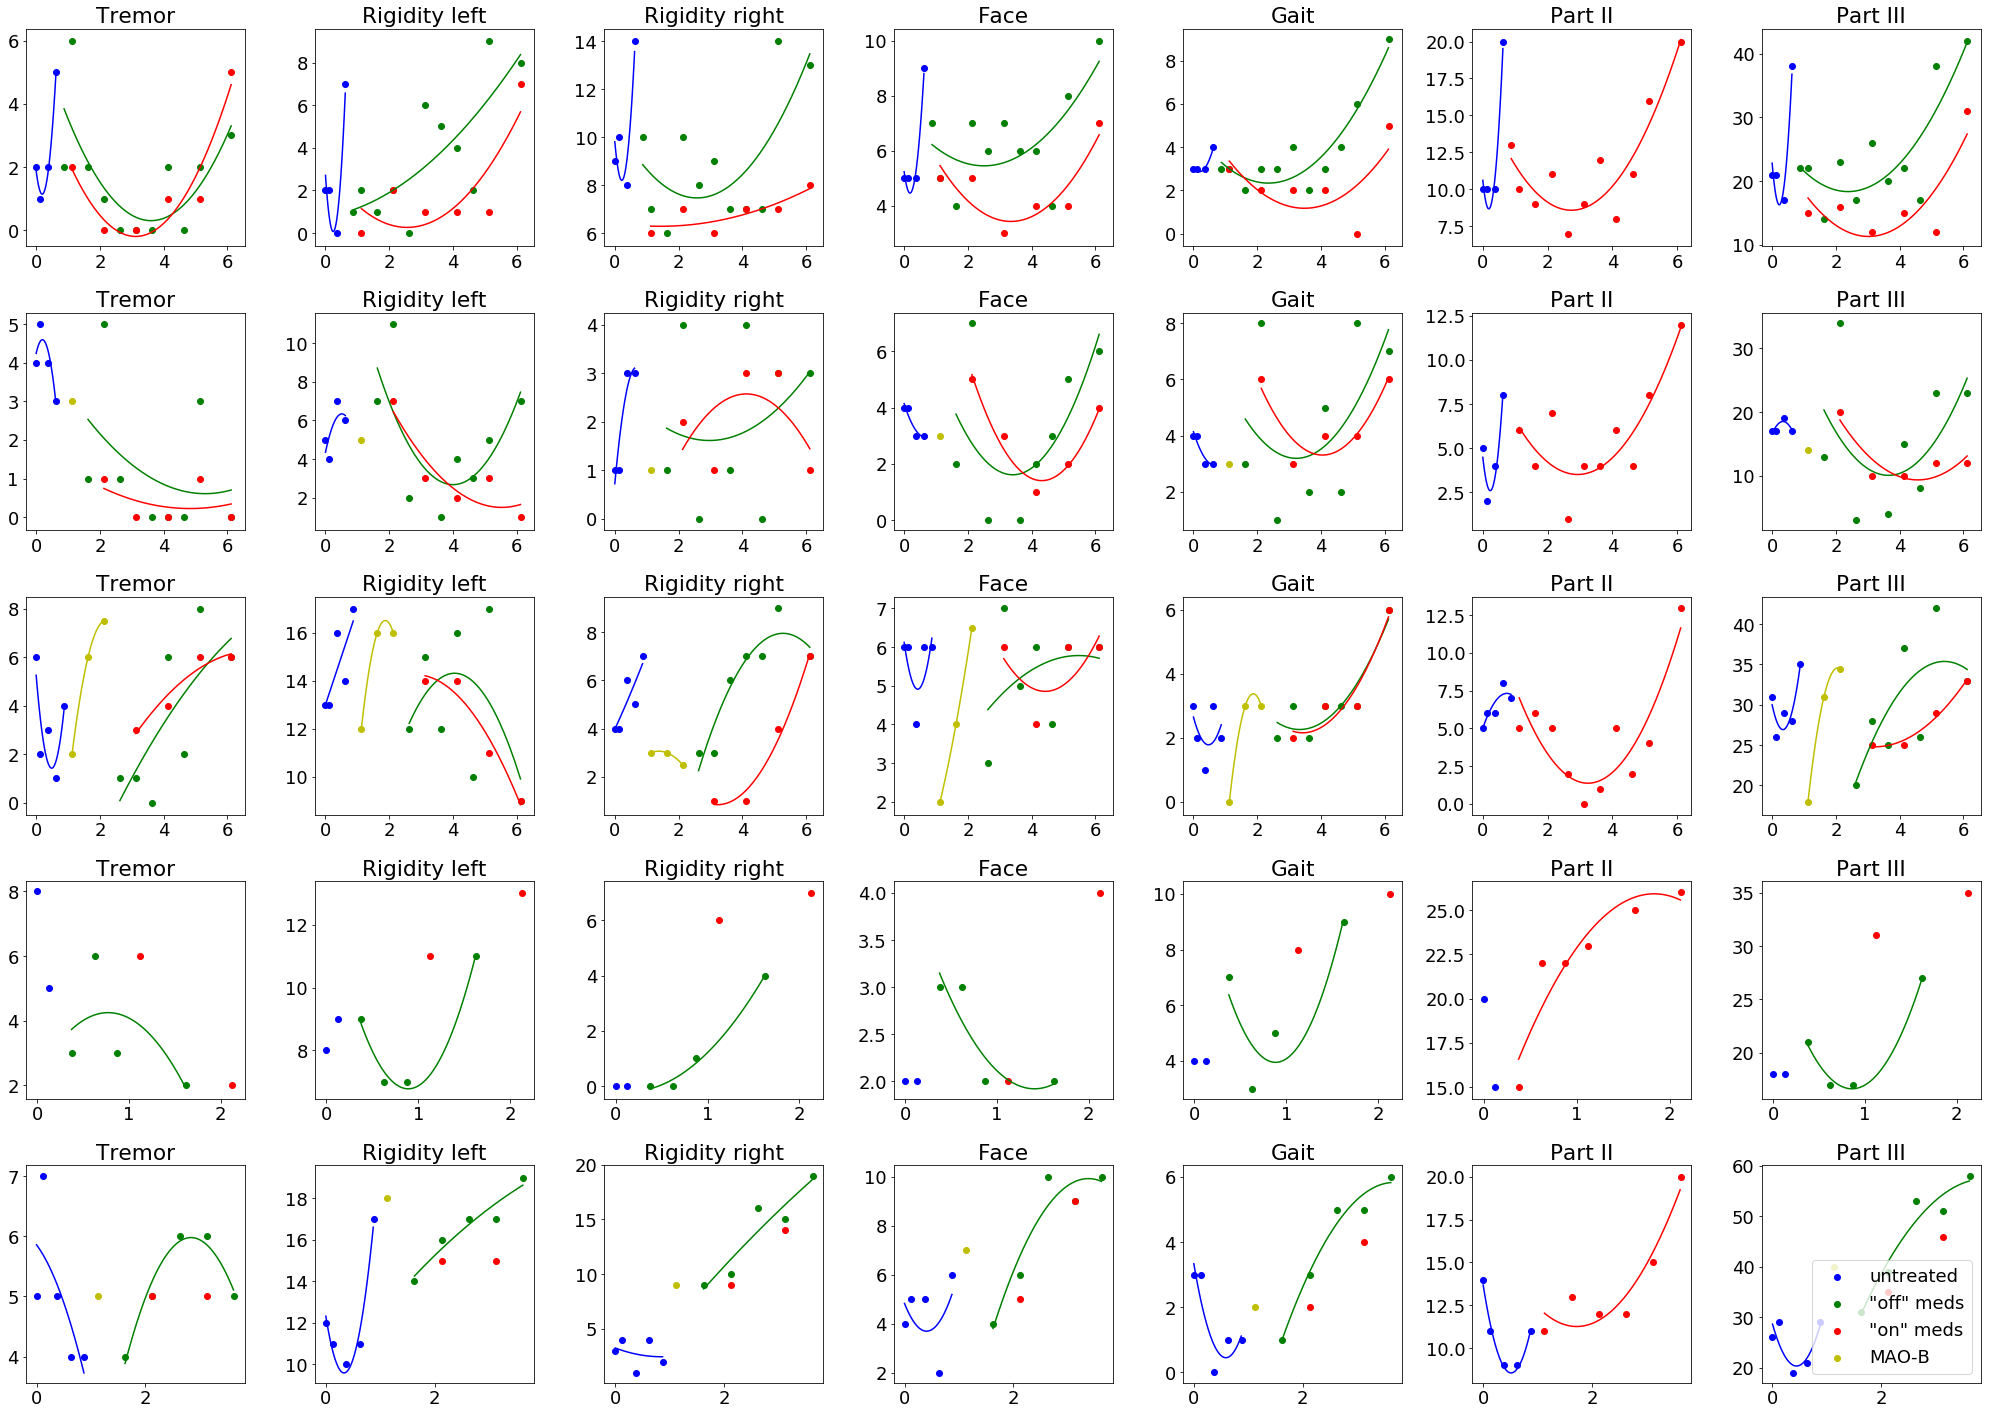

In [18]:
make_mdsupdrs_plot(pd_questions_df, func_fit='quadratic', offset=5)

### Pick function using MSE + changepoint restriction for piecewise functions

In [11]:
def mse_calc(x, y, func, *params):
    return np.mean(np.square(y - func(x, *params)))

def pick_func(x, y):
    # returns best function + its parameters
    if len(x) < 2:
        return None
    lin_params, _ = curve_fit(lin_func, x, y)
    if len(x) < 3:
        return lin_func, lin_params
    lin_mse = mse_calc(x, y, lin_func, *lin_params)
    quadratic_params, _ = curve_fit(quadratic_func, x, y)
    quadratic_mse = mse_calc(x, y, quadratic_func, *quadratic_params)
    if len(x) >= 5:
        piecewise_lin_params, _ = curve_fit(piecewise_lin_func, x, y)
        if piecewise_lin_params[-1] < x[1] or piecewise_lin_params[-1] > x[-2]:
            piecewise_lin_mse = float('inf')
        else:
            piecewise_lin_mse = mse_calc(x, y, piecewise_lin_func, *piecewise_lin_params)
    else:
        piecewise_lin_mse = float('inf')
    if lin_mse <= quadratic_mse and lin_mse <= piecewise_lin_mse:
        return lin_func, lin_params
    elif quadratic_mse <= piecewise_lin_mse:
        return quadratic_func, quadratic_params
    else:
        return piecewise_lin_func, piecewise_lin_params

In [16]:
nupdrs_col_headers = ['NUPDRS_TREMOR', 'NUPDRS_RIGIDITY_LEFT', 'NUPDRS_RIGIDITY_RIGHT', 'NUPDRS_FACE', 'NUPDRS_GAIT', \
                      'NUPDRS_DAILYACT', 'NUPDRS3']
nupdrs_col_labels = ['Tremor', 'Rigidity left', 'Rigidity right', 'Face', 'Gait', 'Part II', 'Part III']
plt.rcParams.update({'font.size': 24})
nupdrs_col_maxs = [15, 20, 20, 12, 12, 27, 60]
nupdrs_col_mins = [0, 0, 0, 0, 0, 0, 0]
def make_mdsupdrs_plot_pick_func(df, offset=0):
    num_rows = 5
    num_cols = len(nupdrs_col_headers)
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))
    for row_idx in range(num_rows):
        patno = selected_patnos[row_idx+offset]
        patno_df = df.loc[df['PATNO']==patno]
        for col_idx in range(len(nupdrs_col_headers)):
            col_header = nupdrs_col_headers[col_idx]
            if col_header != 'NUPDRS_DAILYACT':
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_off',col_header+'_on',\
                                               col_header+'_maob'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
            else:
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_treated'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
       
            untreated_df = patno_col_df.dropna(subset=[col_header+'_untreated'])
            untreated_times = untreated_df.EVENT_ID_DUR.values
            untreated_values = untreated_df[col_header+'_untreated'].values
            if len(untreated_times) > 0:
                ax[row_idx, col_idx].scatter(untreated_times, untreated_values, c='b', label='untreated')
                if len(untreated_times) >= 2:
                    untreated_func, untreated_params = pick_func(untreated_times, untreated_values)
                    untreated_smooth_xs = 0.01*np.arange(100*np.min(untreated_times), 100*np.max(untreated_times))
                    ax[row_idx, col_idx].plot(untreated_smooth_xs, \
                                              untreated_func(untreated_smooth_xs, *untreated_params), 'b', linewidth=4)
            ax[row_idx, col_idx].set_title(nupdrs_col_labels[col_idx])
            ax[row_idx, col_idx].set_ylim([nupdrs_col_mins[col_idx], nupdrs_col_maxs[col_idx]])
            if col_header != 'NUPDRS_DAILYACT':
                off_df = patno_col_df.dropna(subset=[col_header+'_off'])
                off_times = off_df.EVENT_ID_DUR.values
                off_values = off_df[col_header+'_off'].values
                if len(off_times) > 0:
                    ax[row_idx, col_idx].scatter(off_times, off_values, c='g', label='"off" meds')
                    if len(off_times) >= 2:
                        off_func, off_params = pick_func(off_times, off_values)
                        off_smooth_xs = 0.01*np.arange(100*np.min(off_times), 100*np.max(off_times))
                        ax[row_idx, col_idx].plot(off_smooth_xs, off_func(off_smooth_xs, *off_params), 'g', \
                                                  linestyle='dashdot', linewidth=4)

                on_df = patno_col_df.dropna(subset=[col_header+'_on'])
                on_times = on_df.EVENT_ID_DUR.values
                on_values = on_df[col_header+'_on'].values
                if len(on_times) > 0:
                    ax[row_idx, col_idx].scatter(on_times, on_values, c='r', label='"on" meds')
                    if len(on_times) >= 2:
                        on_func, on_params = pick_func(on_times, on_values)
                        on_smooth_xs = 0.01*np.arange(100*np.min(on_times), 100*np.max(on_times))
                        ax[row_idx, col_idx].plot(on_smooth_xs, on_func(on_smooth_xs, *on_params), 'r', \
                                                  linestyle='dotted', linewidth=4)

                maob_df = patno_col_df.dropna(subset=[col_header+'_maob'])
                maob_times = maob_df.EVENT_ID_DUR.values
                maob_values = maob_df[col_header+'_maob'].values
                if len(maob_times) > 0:
                    ax[row_idx, col_idx].scatter(maob_times, maob_values, c='y', label='MAO-B')
                    if len(maob_times) >= 2:
                        maob_func, maob_params = pick_func(maob_times, maob_values)
                        maob_smooth_xs = 0.01*np.arange(100*np.min(maob_times), 100*np.max(maob_times))
                        ax[row_idx, col_idx].plot(maob_smooth_xs, maob_func(maob_smooth_xs, *maob_params), 'y', \
                                                  linestyle='dashed', linewidth=4)
            else:
                treated_df = patno_col_df.dropna(subset=[col_header+'_treated'])
                treated_times = treated_df.EVENT_ID_DUR.values
                treated_values = treated_df[col_header+'_treated'].values
                if len(treated_times) > 0:
                    ax[row_idx, col_idx].scatter(treated_times, treated_values, c='r', label='treated')
                    if len(treated_times) >= 2:
                        treated_func, treated_params = pick_func(treated_times, treated_values)
                        treated_smooth_xs = 0.01*np.arange(100*np.min(treated_times), 100*np.max(treated_times))
                        ax[row_idx, col_idx].plot(treated_smooth_xs, \
                                                  treated_func(treated_smooth_xs, *treated_params), 'r', \
                                                  linestyle='dotted', linewidth=4)
                        
    plt.tight_layout()
    plt.legend()
    plt.savefig('nupdrs_subtotals_nonlinear_offset' + str(offset) + '_asof_2019Jul31.pdf')
    plt.show()

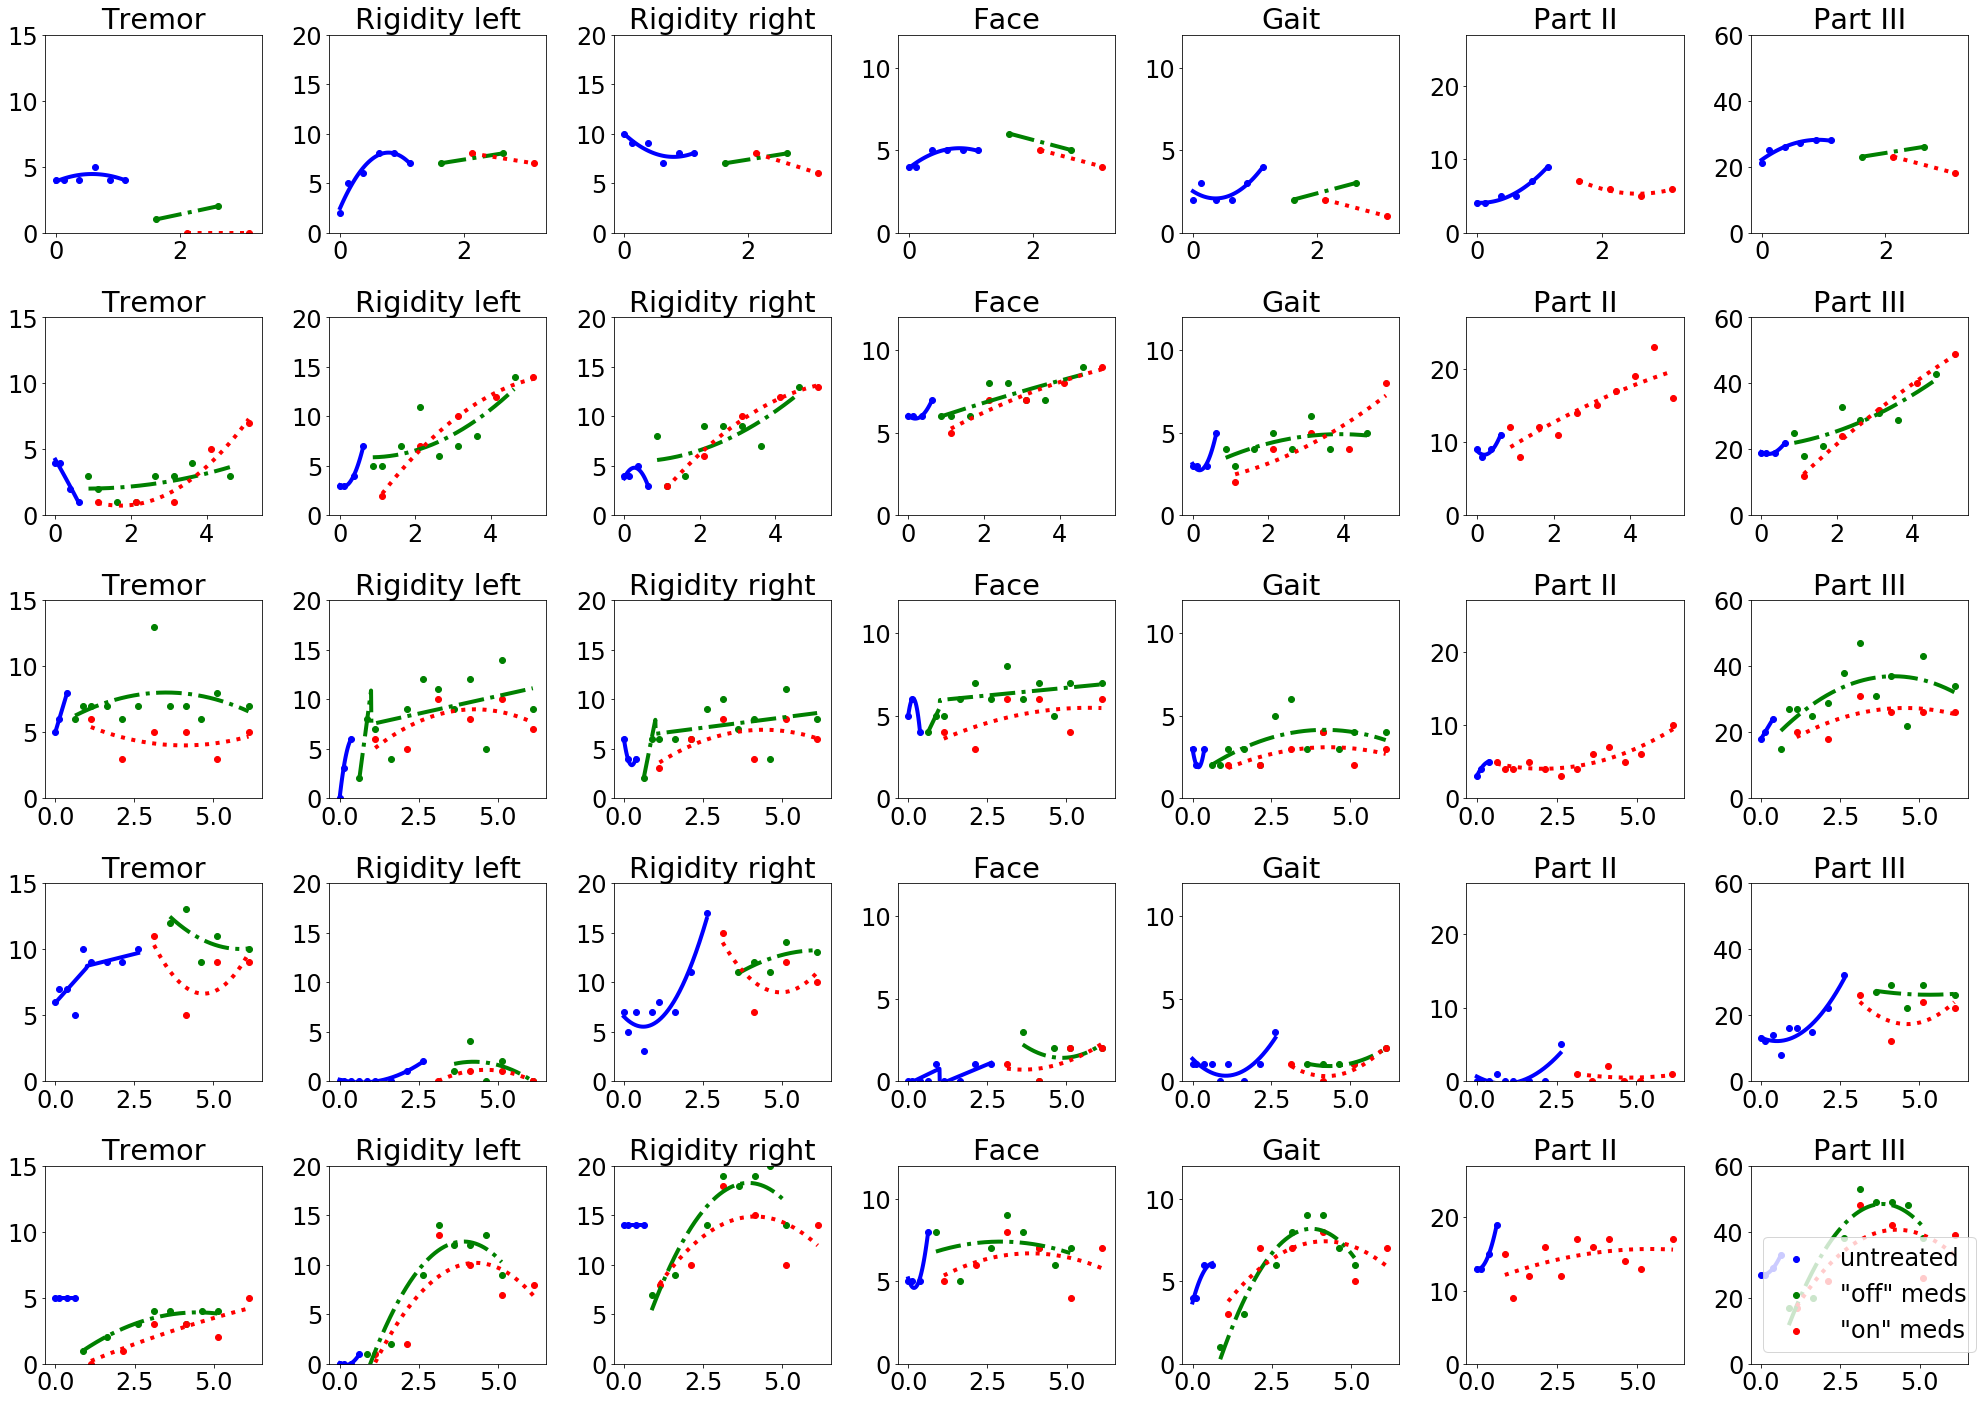

In [17]:
make_mdsupdrs_plot_pick_func(pd_questions_df)

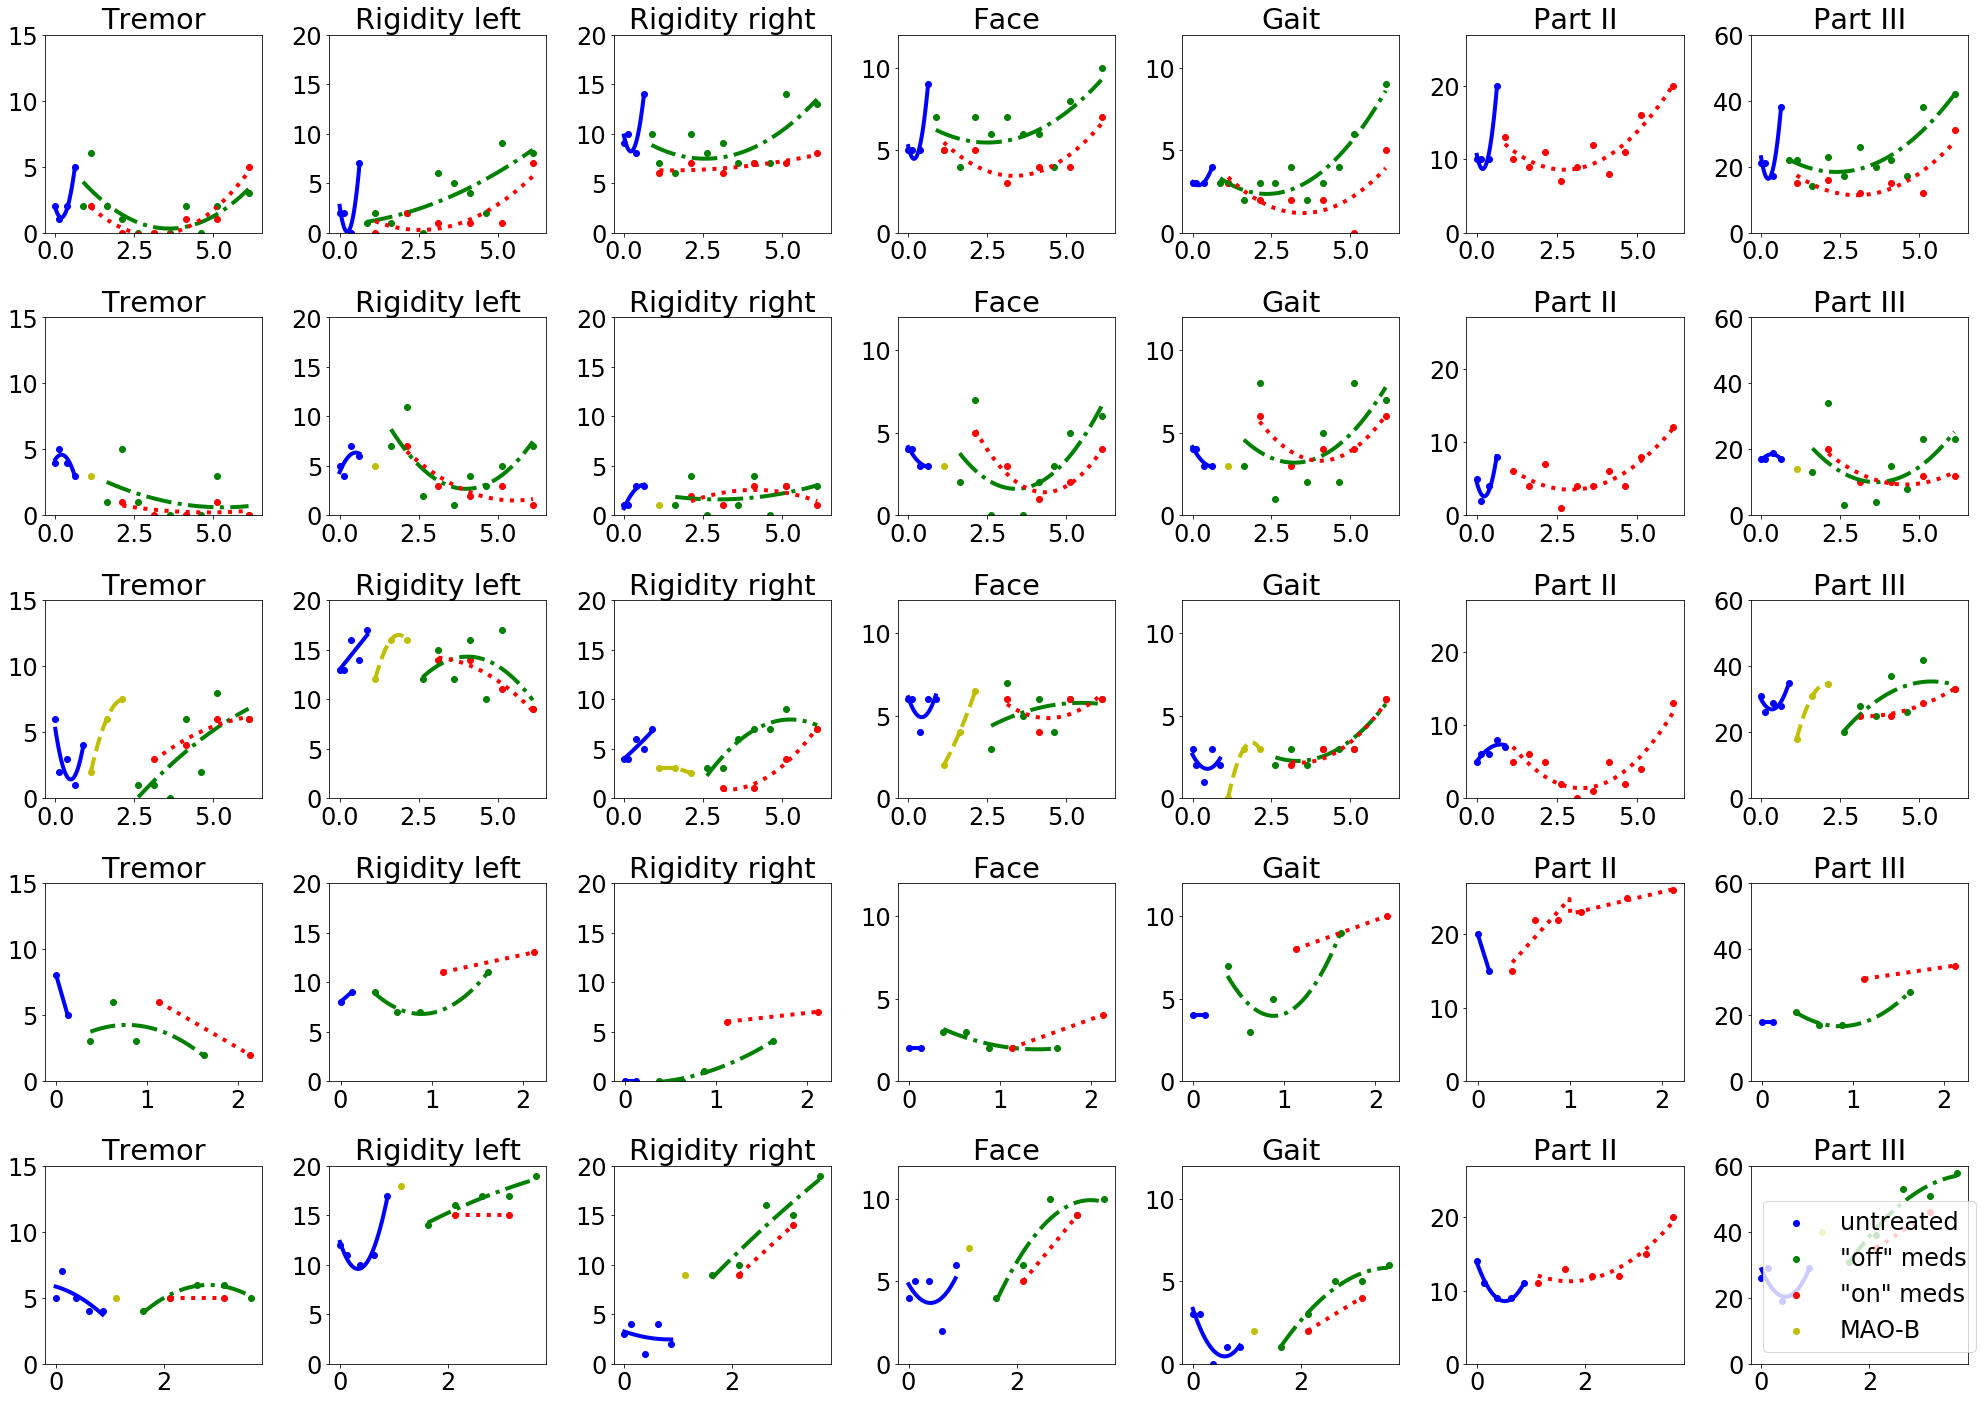

In [18]:
make_mdsupdrs_plot_pick_func(pd_questions_df, offset=5)

### Run k-means clustering on parameters and classify clusters from baseline

In [23]:
def get_patient_params(patno_df):
    # returns dict: subtotal -> {medication state: 7 params}, 0 if missing state
    patno_param_dict = dict()
    for col_header in nupdrs_col_headers:
        patno_param_dict[col_header] = dict()
        if col_header == 'NUPDRS_DAILYACT':
            col_endings = {'untreated', 'treated'}
        else:
            col_endings = {'untreated', 'on', 'off', 'maob'}
        for col_ending in col_endings:
            patno_col_df = patno_df.dropna(subset=[col_header + '_' + col_ending])
            patno_col_times = patno_col_df.EVENT_ID_DUR.values
            patno_col_values = patno_col_df[col_header + '_' + col_ending].values
            if len(patno_col_times) < 2:
                patno_param_dict[col_header][col_ending] = np.zeros(7)
            else:
                _, func_params = pick_func(patno_col_times, patno_col_values)
                if len(func_params) == 2: #linear
                    formatted_params = np.array([0, func_params[0], func_params[1], \
                                                 0, func_params[0], func_params[1], 0])
                elif len(func_params) == 3: # quadratic
                    formatted_params = np.array([func_params[0], func_params[1], func_params[2], \
                                                 func_params[0], func_params[1], func_params[2], 0])
                else: #piecewise linear
                    formatted_params = np.array([0, func_params[0], func_params[1], \
                                                 0, func_params[2], func_params[3], func_params[4]])
                patno_param_dict[col_header][col_ending] = formatted_params
    return patno_param_dict

In [24]:
patno_params_dict = dict()
for patno in pd_questions_df.PATNO.unique():
    print(patno)
    patno_df = pd_questions_df.loc[pd_questions_df['PATNO']==patno]
    patno_params_dict[patno] = get_patient_params(patno_df)

3001
3002
3003
3006
3007
3010
3012
3014
3018
3020
3021
3023
3024
3025
3026
3027
3028
3051
3052
3054
3056
3058
3059
3060
3061
3062
3066
3067
3068
3076
3077
3078
3080
3083
3086
3088
3089
3102
3105
3107
3108
3110
3111
3113
3116
3118
3119
3120
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3134
3150
3154
3162
3166
3168
3173
3174
3175
3176
3178
3179
3180
3181
3182
3184
3185
3186
3190
3203
3205
3207
3209
3211
3212
3214
3218
3220
3223
3224
3225
3226
3227
3228
3229
3230
3231
3233
3234
3251
3252
3253
3254
3267
3268
3269
3272
3275
3278
3279
3280
3281
3282
3284
3285
3288
3290
3305
3307
3308
3309
3311
3312
3313
3314
3321
3322
3323
3325
3327
3328
3330
3332
3333
3352
3354
3359
3360
3364
3365
3366
3367
3371
3372
3373
3374
3375
3376
3377
3378
3380
3383
3385
3386
3387
3392
3400
3403
3406
3407
3409
3415
3417
3418
3419
3420
3421
3422
3423
3429
3430
3431
3432
3433
3434
3435
3436
3439
3440
3442
3443
3444
3445
3446
3448
3451
3454
3455
3459
3461
3462
3467
3469
3470
3471
3472
3473
3475
3476
3482
3500


In [25]:
patno_params_dict[3001]

{'NUPDRS3': {'maob': array([ 0. , 20. , -3.5,  0. , 20. , -3.5,  0. ]),
  'off': array([-0.79212344,  8.90921489, 11.42197774, -0.79212344,  8.90921489,
         11.42197774,  0.        ]),
  'on': array([ 0.34090909, -6.17159091, 51.23884943,  0.34090909, -6.17159091,
         51.23884943,  0.        ]),
  'untreated': array([-6.71825738, 12.11040413, 14.9125824 , -6.71825738, 12.11040413,
         14.9125824 ,  0.        ])},
 'NUPDRS_DAILYACT': {'treated': array([-0.20469083,  2.04975124, -0.08386638, -0.20469083,  2.04975124,
         -0.08386638,  0.        ]),
  'untreated': array([-2.24247635,  2.9588994 ,  0.75580396, -2.24247635,  2.9588994 ,
          0.75580396,  0.        ])},
 'NUPDRS_FACE': {'maob': array([ 0. ,  4. , -1.5,  0. ,  4. , -1.5,  0. ]),
  'off': array([-0.12829238,  1.62589792, -0.15435176, -0.12829238,  1.62589792,
         -0.15435176,  0.        ]),
  'on': array([ 0.86363636, -9.26136364, 27.23508523,  0.86363636, -9.26136364,
         27.23508523,  0.   

In [26]:
# gather parameters
patnos = patno_params_dict.keys()
param_cols = []
subtotals = patno_params_dict[patnos[0]].keys()
subtotals.sort()
for subtotal in subtotals:
    subtotal_settings = patno_params_dict[patnos[0]][subtotal].keys()
    subtotal_settings.sort()
    for treatment_setting in subtotal_settings:
        param_cols.append(subtotal + '_' + treatment_setting)
patno_params_arr = np.empty((len(patnos), len(param_cols)*7))
print(patno_params_arr.shape)
for patno_idx in range(len(patnos)):
    patno = patnos[patno_idx]
    param_idx = 0
    for subtotal in subtotals:
        subtotal_settings = patno_params_dict[patnos[0]][subtotal].keys()
        subtotal_settings.sort()
        for treatment_setting in subtotal_settings:
            patno_params_arr[patno_idx, param_idx:param_idx+7] = patno_params_dict[patno][subtotal][treatment_setting]
            param_idx += 7
    assert param_idx == patno_params_arr.shape[1]

(423, 182)


In [27]:
kmeans_2clusters = KMeans(n_clusters=2, random_state=0).fit(patno_params_arr)
cluster0_idxs = np.nonzero(np.where(kmeans_2clusters.labels_ == 0, 1, 0))[0]
cluster1_idxs = np.nonzero(kmeans_2clusters.labels_)[0]
print(len(cluster0_idxs))
print(len(cluster1_idxs))

422
1


In [28]:
kmeans_2clusters.cluster_centers_

array([[-5.42398382e-01,  2.42307132e+00,  3.87625911e+00,
        -5.42398382e-01,  2.47046468e+00,  3.84347870e+00,
         2.36966825e-03,  3.35862056e-01,  3.84793726e-01,
         2.06696310e+01,  3.35862056e-01,  4.36611878e-01,
         2.06588594e+01,  1.18483412e-02,  1.84772951e-01,
        -2.26563749e-01,  1.75573415e+01,  1.84772951e-01,
        -2.26563749e-01,  1.75573415e+01,  0.00000000e+00,
         9.61948952e+00,  2.30176167e+00,  2.03676267e+01,
         9.61948952e+00,  2.64814551e+00,  2.03031917e+01,
         1.99052133e-01,  2.19027569e-01,  7.72141358e-02,
         5.21972932e+00,  2.19027569e-01,  1.81541345e-01,
         5.13749176e+00,  3.55450237e-02,  3.20700816e+00,
         1.32644904e+00,  4.58558341e+00,  3.20700816e+00,
         1.44363181e+00,  4.50176609e+00,  1.68246445e-01,
        -1.42066125e-02,  5.80972761e-02,  1.21901685e+00,
        -1.42066125e-02,  6.33105462e-02,  1.21409979e+00,
         4.73933649e-03,  4.14845980e-02,  2.79847518e-0

In [29]:
kmeans_3clusters = KMeans(n_clusters=3, random_state=0).fit(patno_params_arr)
cluster0_idxs = np.nonzero(np.where(kmeans_3clusters.labels_ == 0, 1, 0))[0]
cluster1_idxs = np.nonzero(np.where(kmeans_3clusters.labels_ == 1, 1, 0))[0]
cluster2_idxs = np.nonzero(np.where(kmeans_3clusters.labels_ == 2, 1, 0))[0]
print(len(cluster0_idxs))
print(len(cluster1_idxs))
print(len(cluster2_idxs))

412
1
10


In [30]:
kmeans_8clusters = KMeans(n_clusters=8, random_state=0).fit(patno_params_arr)
for idx in range(8):
    print(len(np.nonzero(np.where(kmeans_8clusters.labels_ == idx, 1, 0))[0]))

236
1
3
4
164
7
5
3


In [31]:
kmeans_4clusters = KMeans(n_clusters=4, random_state=0).fit(patno_params_arr)
for idx in range(4):
    print(len(np.nonzero(np.where(kmeans_4clusters.labels_ == idx, 1, 0))[0]))

407
1
5
10


In [32]:
kmeans_5clusters = KMeans(n_clusters=5, random_state=0).fit(patno_params_arr)
for idx in range(5):
    print(len(np.nonzero(np.where(kmeans_5clusters.labels_ == idx, 1, 0))[0]))

5
1
10
87
320


In [33]:
kmeans_6clusters = KMeans(n_clusters=6, random_state=0).fit(patno_params_arr)
for idx in range(6):
    print(len(np.nonzero(np.where(kmeans_6clusters.labels_ == idx, 1, 0))[0]))

305
10
1
79
23
5


In [34]:
kmeans_7clusters = KMeans(n_clusters=7, random_state=0).fit(patno_params_arr)
for idx in range(7):
    print(len(np.nonzero(np.where(kmeans_7clusters.labels_ == idx, 1, 0))[0]))

243
1
160
10
3
3
3


In [35]:
# Use 7 clusters - study the 2 largest clusters
cluster0_idxs = np.nonzero(np.where(kmeans_7clusters.labels_ == 0, 1, 0))[0]
cluster1_idxs = np.nonzero(np.where(kmeans_7clusters.labels_ == 2, 1, 0))[0]
cluster0_patnos = np.array(patnos)[cluster0_idxs]
cluster1_patnos = np.array(patnos)[cluster1_idxs]
cluster0_params = np.array(patno_params_arr)[cluster0_idxs]
cluster1_params = np.array(patno_params_arr)[cluster1_idxs]

In [38]:
param_7_cols = []
letters = ['a','b','c','d','e','f','g']
for col in param_cols:
    for letter in letters:
        param_7_cols.append(col + '_' + letter)
signif_param_idxs = []
for param_idx in range(patno_params_arr.shape[1]):
    _, pval = ttest_ind(cluster0_params[:,param_idx], cluster1_params[:,param_idx], equal_var=False)
    if pval < 0.05:
        signif_param_idxs.append(param_idx)
        print(param_7_cols[param_idx] + ': {0:.4f}'.format(np.mean(cluster0_params[:,param_idx])) \
              + ' ({0:.4f}), '.format(np.std(cluster0_params[:,param_idx])) \
              + '{0:.4f}'.format(np.mean(cluster1_params[:,param_idx])) \
              + ' ({0:.4f})'.format(np.std(cluster1_params[:,param_idx])))
#print(np.array(param_7_cols)[signif_param_idxs])
print(len(signif_param_idxs))

NUPDRS3_off_a: -0.3874 (2.1950), 2.8528 (9.0136)
NUPDRS3_off_b: 4.3593 (16.1784), -15.1503 (29.0399)
NUPDRS3_off_c: 9.2619 (30.3829), 51.6279 (52.7181)
NUPDRS3_off_d: -0.3874 (2.1950), 2.8528 (9.0136)
NUPDRS3_off_e: 4.5672 (15.9523), -15.0822 (29.0647)
NUPDRS3_off_f: 9.1763 (30.3189), 51.5636 (52.7540)
NUPDRS3_on_a: -0.5778 (2.0740), 1.1001 (2.7409)
NUPDRS3_on_b: 6.3837 (19.6355), -7.3182 (18.7632)
NUPDRS3_on_c: -0.5761 (47.1235), 35.9171 (37.1020)
NUPDRS3_on_d: -0.5778 (2.0740), 1.1001 (2.7409)
NUPDRS3_on_e: 6.3837 (19.6355), -7.3182 (18.7632)
NUPDRS3_on_f: -0.5761 (47.1235), 35.9171 (37.1020)
NUPDRS3_untreated_a: -11.5643 (40.3021), 33.6865 (43.7013)
NUPDRS3_untreated_b: 14.2850 (27.2445), -12.3405 (27.4679)
NUPDRS3_untreated_c: 18.0413 (7.5108), 23.7938 (9.2602)
NUPDRS3_untreated_d: -11.5643 (40.3021), 33.6865 (43.7013)
NUPDRS3_untreated_e: 14.5417 (27.2094), -11.7730 (27.8619)
NUPDRS3_untreated_f: 17.9309 (9.4664), 23.6767 (10.2986)
NUPDRS3_untreated_g: 0.2222 (0.4157), 0.1375 (0.3

In [39]:
param_7_cols = []
letters = ['a','b','c','d','e','f','g']
for col in param_cols:
    for letter in letters:
        param_7_cols.append(col + '_' + letter)
signif_param_idxs = []
for param_idx in range(patno_params_arr.shape[1]):
    _, pval = ttest_ind(cluster0_params[:,param_idx], cluster1_params[:,param_idx], equal_var=False)
    if pval < 0.0005:
        signif_param_idxs.append(param_idx)
        print(param_7_cols[param_idx] + ': {0:.4f}'.format(np.mean(cluster0_params[:,param_idx])) \
              + ' ({0:.4f}), '.format(np.std(cluster0_params[:,param_idx])) \
              + '{0:.4f}'.format(np.mean(cluster1_params[:,param_idx])) \
              + ' ({0:.4f})'.format(np.std(cluster1_params[:,param_idx])))
#print(np.array(param_7_cols)[signif_param_idxs])
print(len(signif_param_idxs))

NUPDRS3_off_a: -0.3874 (2.1950), 2.8528 (9.0136)
NUPDRS3_off_b: 4.3593 (16.1784), -15.1503 (29.0399)
NUPDRS3_off_c: 9.2619 (30.3829), 51.6279 (52.7181)
NUPDRS3_off_d: -0.3874 (2.1950), 2.8528 (9.0136)
NUPDRS3_off_e: 4.5672 (15.9523), -15.0822 (29.0647)
NUPDRS3_off_f: 9.1763 (30.3189), 51.5636 (52.7540)
NUPDRS3_on_a: -0.5778 (2.0740), 1.1001 (2.7409)
NUPDRS3_on_b: 6.3837 (19.6355), -7.3182 (18.7632)
NUPDRS3_on_c: -0.5761 (47.1235), 35.9171 (37.1020)
NUPDRS3_on_d: -0.5778 (2.0740), 1.1001 (2.7409)
NUPDRS3_on_e: 6.3837 (19.6355), -7.3182 (18.7632)
NUPDRS3_on_f: -0.5761 (47.1235), 35.9171 (37.1020)
NUPDRS3_untreated_a: -11.5643 (40.3021), 33.6865 (43.7013)
NUPDRS3_untreated_b: 14.2850 (27.2445), -12.3405 (27.4679)
NUPDRS3_untreated_c: 18.0413 (7.5108), 23.7938 (9.2602)
NUPDRS3_untreated_d: -11.5643 (40.3021), 33.6865 (43.7013)
NUPDRS3_untreated_e: 14.5417 (27.2094), -11.7730 (27.8619)
NUPDRS3_untreated_f: 17.9309 (9.4664), 23.6767 (10.2986)
NUPDRS_FACE_off_b: 0.8222 (3.5451), -2.2056 (8.51

In [40]:
# get significantly different baseline features
datadir = '../gather_PD_data/'
baseline_df = pd.read_csv(datadir + 'selected_baseline_data_using_CMEDTM.csv')
del baseline_df['ENROLL_CAT']
longitudinal_df = pd.read_csv(datadir + 'selected_longitudinal_data_using_CMEDTM.csv')
screening_longitudinal_df = longitudinal_df.loc[longitudinal_df['EVENT_ID_DUR']==0]
baseline_longitudinal_df = longitudinal_df.loc[longitudinal_df['EVENT_ID_DUR']==0.125]
screening_longitudinal_cols = ['NUPDRS1', 'MOCA', 'NUPDRS2_DAILYACT', 'NUPDRS3_GAIT', 'NUPDRS3_RIGID_RIGHT', \
                               'NUPDRS3_FACE', 'NUPDRS3_TREMOR', 'NUPDRS3_RIGID_LEFT']
baseline_longitudinal_cols = ['SCOPA-AUT', 'HVLT_discrim_recog', 'STAI', 'HVLT_immed_recall', 'QUIP', 'EPWORTH', \
                              'GDSSHORT', 'HVLT_retent', 'BJLO', 'LNS', 'SEMANTIC_FLUENCY', 'REMSLEEP']
baseline_df = baseline_df.merge(screening_longitudinal_df[['PATNO']+screening_longitudinal_cols], on=['PATNO'], \
                                validate='one_to_one')
baseline_df = baseline_df.merge(baseline_longitudinal_df[['PATNO']+baseline_longitudinal_cols], on=['PATNO'], \
                                validate='one_to_one')

In [41]:
cluster0_baseline_df = baseline_df.loc[baseline_df['PATNO'].isin(cluster0_patnos)]
cluster1_baseline_df = baseline_df.loc[baseline_df['PATNO'].isin(cluster1_patnos)]

In [43]:
signif_baseline_feats = []
for col in baseline_df.columns.values[1:]:
    cluster0_col = cluster0_baseline_df[col].dropna().values
    cluster1_col = cluster1_baseline_df[col].dropna().values
    _, pval = ttest_ind(cluster0_col, cluster1_col, equal_var=False)
    if pval < 0.0005:
        signif_baseline_feats.append(col)
        print(col + ': {0:.4f}'.format(np.mean(cluster0_col)) + ' ({0:.4f}), '.format(np.std(cluster0_col)) \
              + '{0:.4f}'.format(np.mean(cluster1_col)) + ' ({0:.4f})'.format(np.std(cluster1_col)))
#print(signif_baseline_feats)

NUPDRS3_FACE: 3.0986 (1.9584), 4.1643 (2.1435)
NUPDRS3_RIGID_LEFT: 4.4836 (4.6417), 7.1000 (4.9919)


In [44]:
signif_baseline_feats = []
for col in baseline_df.columns.values[1:]:
    cluster0_col = cluster0_baseline_df[col].dropna().values
    cluster1_col = cluster1_baseline_df[col].dropna().values
    _, pval = ttest_ind(cluster0_col, cluster1_col, equal_var=False)
    if pval < 0.05:
        signif_baseline_feats.append(col)
        print(col + ': {0:.4f}'.format(np.mean(cluster0_col)) + ' ({0:.4f}), '.format(np.std(cluster0_col)) \
              + '{0:.4f}'.format(np.mean(cluster1_col)) + ' ({0:.4f})'.format(np.std(cluster1_col)))
#print(signif_baseline_feats)

UPSIT: 23.1455 (7.6307), 21.2857 (8.3950)
AGE: 60.4445 (9.2546), 63.5070 (9.5131)
ipsilateral_putamen: 0.9998 (0.3827), 0.8790 (0.3480)
count_density_ratio_ipsilateral: 2.3119 (0.6356), 2.5387 (0.6684)
contralateral_putamen: 0.7091 (0.2689), 0.6492 (0.2248)
NUPDRS3_GAIT: 1.2535 (1.1913), 1.5929 (1.3570)
NUPDRS3_RIGID_RIGHT: 4.9577 (3.8387), 6.1357 (4.2648)
NUPDRS3_FACE: 3.0986 (1.9584), 4.1643 (2.1435)
NUPDRS3_RIGID_LEFT: 4.4836 (4.6417), 7.1000 (4.9919)
QUIP: 0.3380 (0.6976), 0.1786 (0.4515)
LNS: 10.8638 (2.5811), 9.9143 (2.6308)
SEMANTIC_FLUENCY: 50.1315 (11.5682), 47.1500 (11.5443)


In [45]:
signif_baseline_feats = []
for col in baseline_df.columns.values[1:]:
    cluster0_col = cluster0_baseline_df[col].dropna().values
    cluster1_col = cluster1_baseline_df[col].dropna().values
    _, pval = ttest_ind(cluster0_col, cluster1_col, equal_var=False)
    if pval < 0.005:
        signif_baseline_feats.append(col)
        print(col + ': {0:.4f}'.format(np.mean(cluster0_col)) + ' ({0:.4f}), '.format(np.std(cluster0_col)) \
              + '{0:.4f}'.format(np.mean(cluster1_col)) + ' ({0:.4f})'.format(np.std(cluster1_col)))
#print(signif_baseline_feats)

AGE: 60.4445 (9.2546), 63.5070 (9.5131)
ipsilateral_putamen: 0.9998 (0.3827), 0.8790 (0.3480)
count_density_ratio_ipsilateral: 2.3119 (0.6356), 2.5387 (0.6684)
NUPDRS3_FACE: 3.0986 (1.9584), 4.1643 (2.1435)
NUPDRS3_RIGID_LEFT: 4.4836 (4.6417), 7.1000 (4.9919)
LNS: 10.8638 (2.5811), 9.9143 (2.6308)


In [46]:
# get the proportion of patients that use each functional form
# linear if a = 0 and g = 0
# quadratic if a != 0
# piecewise linear if g != 0
setting_counts = dict()
for subtotal in patno_params_dict[patnos[0]].keys():
    setting_counts[subtotal] = dict()
    for setting in patno_params_dict[patnos[0]][subtotal].keys():
        setting_counts[subtotal][setting] = {'linear': 0, 'piecewise_linear': 0, 'quadratic': 0}
for patno in patno_params_dict.keys():
    for subtotal in patno_params_dict[patno].keys():
        for setting in patno_params_dict[patno][subtotal].keys():
            params = patno_params_dict[patno][subtotal][setting]
            if len(np.nonzero(params)[0]) > 0:
                if params[0] != 0:
                    setting_counts[subtotal][setting]['quadratic'] += 1
                elif params[-1] != 0:
                    setting_counts[subtotal][setting]['piecewise_linear'] += 1
                else:
                    setting_counts[subtotal][setting]['linear'] += 1

In [47]:
print(setting_counts)

{'NUPDRS_RIGIDITY_RIGHT': {'on': {'quadratic': 278, 'linear': 60, 'piecewise_linear': 0}, 'off': {'quadratic': 316, 'linear': 35, 'piecewise_linear': 9}, 'untreated': {'quadratic': 308, 'linear': 38, 'piecewise_linear': 74}, 'maob': {'quadratic': 62, 'linear': 40, 'piecewise_linear': 2}}, 'NUPDRS_RIGIDITY_LEFT': {'on': {'quadratic': 270, 'linear': 58, 'piecewise_linear': 0}, 'off': {'quadratic': 316, 'linear': 35, 'piecewise_linear': 8}, 'untreated': {'quadratic': 300, 'linear': 43, 'piecewise_linear': 77}, 'maob': {'quadratic': 63, 'linear': 39, 'piecewise_linear': 1}}, 'NUPDRS_GAIT': {'on': {'quadratic': 241, 'linear': 83, 'piecewise_linear': 1}, 'off': {'quadratic': 297, 'linear': 52, 'piecewise_linear': 7}, 'untreated': {'quadratic': 280, 'linear': 63, 'piecewise_linear': 75}, 'maob': {'quadratic': 49, 'linear': 49, 'piecewise_linear': 2}}, 'NUPDRS_TREMOR': {'on': {'quadratic': 266, 'linear': 66, 'piecewise_linear': 1}, 'off': {'quadratic': 314, 'linear': 39, 'piecewise_linear': 6}

In [48]:
# get proportion of patients with each functional form in each cluster
cluster0_setting_counts = dict()
cluster1_setting_counts = dict()
for subtotal in patno_params_dict[patnos[0]].keys():
    cluster0_setting_counts[subtotal] = dict()
    cluster1_setting_counts[subtotal] = dict()
    for setting in patno_params_dict[patnos[0]][subtotal].keys():
        cluster0_setting_counts[subtotal][setting] = {'linear': 0, 'piecewise_linear': 0, 'quadratic': 0}
        cluster1_setting_counts[subtotal][setting] = {'linear': 0, 'piecewise_linear': 0, 'quadratic': 0}
for patno in patno_params_dict.keys():
    for subtotal in patno_params_dict[patno].keys():
        for setting in patno_params_dict[patno][subtotal].keys():
            params = patno_params_dict[patno][subtotal][setting]
            if len(np.nonzero(params)[0]) > 0:
                if patno in cluster0_patnos:
                    if params[0] != 0:
                        cluster0_setting_counts[subtotal][setting]['quadratic'] += 1
                    elif params[-1] != 0:
                        cluster0_setting_counts[subtotal][setting]['piecewise_linear'] += 1
                    else:
                        cluster0_setting_counts[subtotal][setting]['linear'] += 1
                elif patno in cluster1_patnos:
                    if params[0] != 0:
                        cluster1_setting_counts[subtotal][setting]['quadratic'] += 1
                    elif params[-1] != 0:
                        cluster1_setting_counts[subtotal][setting]['piecewise_linear'] += 1
                    else:
                        cluster1_setting_counts[subtotal][setting]['linear'] += 1

In [49]:
print(cluster0_setting_counts)

{'NUPDRS_RIGIDITY_RIGHT': {'on': {'quadratic': 144, 'linear': 29, 'piecewise_linear': 0}, 'off': {'quadratic': 155, 'linear': 23, 'piecewise_linear': 7}, 'untreated': {'quadratic': 163, 'linear': 29, 'piecewise_linear': 49}, 'maob': {'quadratic': 34, 'linear': 25, 'piecewise_linear': 1}}, 'NUPDRS_RIGIDITY_LEFT': {'on': {'quadratic': 135, 'linear': 29, 'piecewise_linear': 0}, 'off': {'quadratic': 157, 'linear': 22, 'piecewise_linear': 5}, 'untreated': {'quadratic': 159, 'linear': 31, 'piecewise_linear': 51}, 'maob': {'quadratic': 34, 'linear': 24, 'piecewise_linear': 1}}, 'NUPDRS_GAIT': {'on': {'quadratic': 125, 'linear': 41, 'piecewise_linear': 0}, 'off': {'quadratic': 148, 'linear': 32, 'piecewise_linear': 4}, 'untreated': {'quadratic': 149, 'linear': 44, 'piecewise_linear': 47}, 'maob': {'quadratic': 27, 'linear': 29, 'piecewise_linear': 1}}, 'NUPDRS_TREMOR': {'on': {'quadratic': 139, 'linear': 32, 'piecewise_linear': 0}, 'off': {'quadratic': 156, 'linear': 25, 'piecewise_linear': 3}

In [50]:
print(cluster1_setting_counts)

{'NUPDRS_RIGIDITY_RIGHT': {'on': {'quadratic': 127, 'linear': 23, 'piecewise_linear': 0}, 'off': {'quadratic': 146, 'linear': 10, 'piecewise_linear': 1}, 'untreated': {'quadratic': 132, 'linear': 9, 'piecewise_linear': 18}, 'maob': {'quadratic': 19, 'linear': 13, 'piecewise_linear': 1}}, 'NUPDRS_RIGIDITY_LEFT': {'on': {'quadratic': 127, 'linear': 22, 'piecewise_linear': 0}, 'off': {'quadratic': 144, 'linear': 11, 'piecewise_linear': 2}, 'untreated': {'quadratic': 127, 'linear': 12, 'piecewise_linear': 21}, 'maob': {'quadratic': 20, 'linear': 13, 'piecewise_linear': 0}}, 'NUPDRS_GAIT': {'on': {'quadratic': 108, 'linear': 35, 'piecewise_linear': 1}, 'off': {'quadratic': 134, 'linear': 19, 'piecewise_linear': 2}, 'untreated': {'quadratic': 121, 'linear': 18, 'piecewise_linear': 20}, 'maob': {'quadratic': 15, 'linear': 16, 'piecewise_linear': 1}}, 'NUPDRS_TREMOR': {'on': {'quadratic': 120, 'linear': 27, 'piecewise_linear': 1}, 'off': {'quadratic': 142, 'linear': 13, 'piecewise_linear': 2},

In [75]:
# Make barplots for each set of distributions
def make_barplot(setting_counts, cluster0_setting_counts, cluster1_settting_counts):
    plt.rcParams.update({'font.size': 14})
    subtotals = setting_counts.keys()
    part3_total_idx = subtotals.index('NUPDRS3') # move this to end
    subtotals = subtotals[:part3_total_idx] + subtotals[part3_total_idx+1:] + ['NUPDRS3']
    fig, ax = plt.subplots(nrows=4, ncols=len(subtotals), sharey=True, sharex=True, figsize=(20,10))
    for subtotal_idx in range(len(subtotals)):
        subtotal = subtotals[subtotal_idx]
        if subtotal == 'NUPDRS_DAILYACT':
            settings = ['untreated', 'treated']
        else:
            settings = ['untreated', 'on', 'off', 'maob']
        for row_idx in range(len(settings)):
            # plot order: linear, quadratic, piecewise linear
            setting = settings[row_idx]
            total_y = np.array([setting_counts[subtotal][setting]['linear'], \
                                setting_counts[subtotal][setting]['quadratic'], \
                                setting_counts[subtotal][setting]['piecewise_linear']])
            cluster0_y = np.array([cluster0_setting_counts[subtotal][setting]['linear'], \
                                   cluster0_setting_counts[subtotal][setting]['quadratic'], \
                                   cluster0_setting_counts[subtotal][setting]['piecewise_linear']])
            cluster1_y = np.array([cluster1_setting_counts[subtotal][setting]['linear'], \
                                   cluster1_setting_counts[subtotal][setting]['quadratic'], \
                                   cluster1_setting_counts[subtotal][setting]['piecewise_linear']])
            x = np.array([0,1,2])
            ax[row_idx,subtotal_idx].bar(x-0.2, total_y, width=0.2, color='b', align='center', label='Total')
            ax[row_idx,subtotal_idx].bar(x, cluster0_y, width=0.2, color='g', align='center', label='Cluster 0')
            ax[row_idx,subtotal_idx].bar(x+0.2, cluster1_y, width=0.2, color='r', align='center', label='Cluster 1')
        if subtotal == 'NUPDRS3':
            subtotal_title = 'Part III total'
        else:
            subtotal_title = subtotal[7:].lower().replace('_', ' ')
        ax[0,subtotal_idx].set_title(subtotal_title)
        ax[3,subtotal_idx].set_xticklabels(['','linear','quadratic','piecewise_linear'], rotation=90)
    for row_idx in range(len(settings)):
        ax[row_idx,0].set_ylabel(settings[row_idx])
    ax[3,len(subtotals)-1].legend()
    plt.tight_layout()
    plt.show()

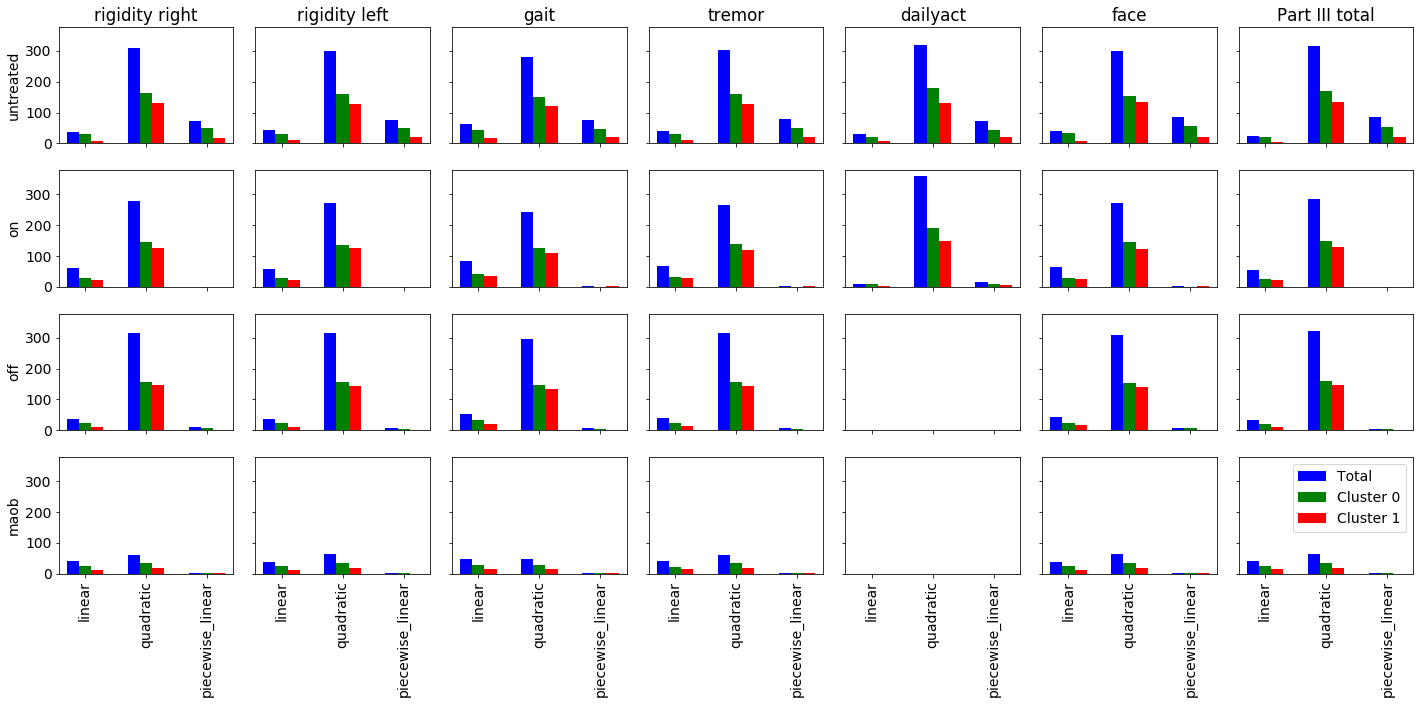

In [76]:
make_barplot(setting_counts, cluster0_setting_counts, cluster1_setting_counts)

differences don't seem to be in distribution of functional forms<br>
Also seems to be generating more dimensions than originally present in data...is this only to handle diff # of data points?